
## 1. Importar Bibliotecas e Carregar Dataset Preprocessado

In [141]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

import sklearn

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.2
NumPy: 2.3.3
Scikit-learn: 1.7.2


In [142]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar datasets pré-processados
train_data = pd.read_csv('dataset_sepsis_prepared.csv')
test_data = pd.read_csv('dataset_sepsis_test_prepared.csv')

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

# Separar features e target
X_train = train_data.drop('SepsisLabel', axis=1)
y_train = train_data['SepsisLabel']
X_test = test_data.drop('SepsisLabel', axis=1)
y_test = test_data['SepsisLabel']

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...
Dataset de treino: (853006, 19)
Dataset de teste: (215171, 19)

Distribuição das classes:
Treino: {0.0: 831112, 1.0: 21894}
Teste: {0.0: 209675, 1.0: 5496}


## 2. Sampling para Busca de Hiperparâmetros

In [87]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Dataset completo é muito grande (>1M instâncias) para busca de hiperparâmetros
# Vamos usar uma amostra estratificada de 4% para otimização
from sklearn.model_selection import train_test_split

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.005,  
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 4,266 amostras
Redução: 99.5%

Distribuição das classes na amostra:
Amostra: {0.0: 4157, 1.0: 109}
Original: {0.0: 831112, 1.0: 21894}


## 3. Funções Auxiliares

In [ ]:
# Função auxiliar para cálculo do G-Mean
def gmean_score(y_true, y_pred):
    """Calcula o G-Mean (Geometric Mean) para problemas binários"""
    # Sensitivity (recall da classe positiva - sepsis)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    # Specificity (recall da classe negativa - sem sepsis)
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    # G-Mean é a média geométrica de sensitivity e specificity
    return np.sqrt(sensitivity * specificity)

# Função para avaliar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia um modelo treinado e retorna métricas completas"""
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de treino
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred, zero_division=0),
        'recall': recall_score(y_train, y_train_pred, zero_division=0),
        'f1': f1_score(y_train, y_train_pred, zero_division=0),
        'gmean': gmean_score(y_train, y_train_pred)
    }
    
    # Métricas de teste
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, zero_division=0),
        'recall': recall_score(y_test, y_test_pred, zero_division=0),
        'f1': f1_score(y_test, y_test_pred, zero_division=0),
        'gmean': gmean_score(y_test, y_test_pred)
    }
    
    # AUC-ROC para problemas binários
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva
        test_metrics['auc_roc'] = roc_auc_score(y_test, y_test_proba)
        
        # AUC-ROC para treino também
        y_train_proba = model.predict_proba(X_train)[:, 1]
        train_metrics['auc_roc'] = roc_auc_score(y_train, y_train_proba)
    except Exception as e:
        test_metrics['auc_roc'] = None
        train_metrics['auc_roc'] = None
    
    return train_metrics, test_metrics, y_test_pred

# Função para plotar histórico de busca
def plot_search_history(all_search_results, search_results, model_name, metric='mean_test_score'):
    """Plota a evolução dos resultados durante a busca de hiperparâmetros"""
        
    plt.figure(figsize=(15, 6))
        
    results_df = pd.DataFrame(search_results.cv_results_)
    # Extrair melhor score de cada busca
    search_scores = []
    search_indices = []
    
    for i, search_result in enumerate(all_search_results):
        search_scores.append(search_result['best_score'])
        search_indices.append(i + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(search_indices, search_scores, 'b-o', alpha=0.8, markersize=8)
    plt.title(f'{model_name} - Melhor F1-Score por Busca')
    plt.xlabel('Número da Busca')
    plt.ylabel('Melhor F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Destacar a melhor busca
    best_idx = search_scores.index(max(search_scores))
    plt.plot(search_indices[best_idx], search_scores[best_idx], 'ro', markersize=12, 
            label=f'Melhor: {search_scores[best_idx]:.4f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Verificar se existe coluna de treino
    if 'mean_train_score' in results_df.columns:
        # Plotar treino com sombra
        plt.plot(results_df['mean_train_score'], 'g-o', alpha=0.7, label='Treino')
        plt.fill_between(range(len(results_df)), 
                        results_df['mean_train_score'] - results_df['std_train_score'],
                        results_df['mean_train_score'] + results_df['std_train_score'], 
                        color='green', alpha=0.2)
    
    # Plotar validação com sombra
    plt.plot(results_df[metric], 'b-o', alpha=0.7, label='Validação')
    plt.fill_between(range(len(results_df)), 
                    results_df[metric] - results_df['std_test_score'],
                    results_df[metric] + results_df['std_test_score'], 
                    color='blue', alpha=0.3)
    
    # DESTACAR A MELHOR ITERAÇÃO
    best_iteration_idx = results_df[metric].idxmax()
    best_iteration_score = results_df[metric].iloc[best_iteration_idx]
    
    plt.plot(best_iteration_idx, best_iteration_score, 'ro', markersize=15, 
            markeredgecolor='darkred', markeredgewidth=2,
            label=f'Melhor iteração: #{best_iteration_idx + 1} ({best_iteration_score:.4f})')
    
    plt.title(f'{model_name} - Treino vs Validação (Melhor Busca)')
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Função para executar múltiplas buscas de hiperparâmetros
def multiple_randomized_search(estimator, param_distributions, X, y, cv_strategy, 
                              n_searches=20, n_iter_per_search=80, scoring='f1', 
                              random_state=42, n_jobs=-1, verbose=0):
    """
    Executa múltiplas buscas RandomizedSearchCV e retorna a melhor configuração global
    
    Parameters:
    -----------
    n_searches : int
        Número de execuções do RandomizedSearchCV (default: 20)
    n_iter_per_search : int  
        Número de iterações por execução (default: 80)
    """
    print(f"Executando {n_searches} buscas com {n_iter_per_search} iterações cada...")
    
    best_overall_score = -np.inf
    best_overall_params = None
    best_search_result = None
    all_results = []
    
    for search_idx in range(n_searches):
        print(f"\nBusca {search_idx + 1}/{n_searches}...")
        
        # RandomizedSearchCV para esta execução
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_distributions,
            n_iter=n_iter_per_search,
            scoring=scoring,
            cv=cv_strategy,
            random_state=None,
            n_jobs=n_jobs,
            return_train_score=True,
            verbose=0  # Menos verbose para múltiplas execuções
        )
        
        search.fit(X, y)
        
        # Armazenar resultados desta busca
        search_results = {
            'search_idx': search_idx,
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'cv_results': search.cv_results_
        }
        all_results.append(search_results)
        
        # Verificar se esta é a melhor busca até agora
        if search.best_score_ > best_overall_score:
            best_overall_score = search.best_score_
            best_overall_params = search.best_params_
            best_search_result = search
            
        print(f"Melhor score desta busca: {search.best_score_:.4f}")
        print(f"Melhor configuração desta busca: {search.best_params_}")
        print(f"Melhor score geral até agora: {best_overall_score:.4f}")
    
    print(f"\n🎯 Busca completa! Melhor score geral: {best_overall_score:.4f}")
    print(f"Total de configurações testadas: {n_searches * n_iter_per_search:,}")
    
    return best_search_result, all_results, best_overall_params

print("Funções auxiliares definidas com sucesso!")

Funções auxiliares definidas com sucesso!


## 3.1 Definir Folders

In [79]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## 4. KNN - Busca de Hiperparâmetros
Amostra de 4%; Random State = 42 para a busca

In [19]:
# ======================================================================
# 4.1 K-NEAREST NEIGHBORS (KNN) - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - KNN ===")

# 4.3 Definição do Espaço de Hiperparâmetros para KNN
knn_param_distributions = {
    'n_neighbors': randint(1, 25),           # Número de vizinhos
    'metric': ['euclidean', 'manhattan'],    # Métrica de distância
    'weights': ['uniform', 'distance'],      # Peso dos vizinhos
}

# 4.1 Múltiplas execuções do RandomizedSearchCV
print("Iniciando busca de hiperparâmetros para KNN...")
knn_search, knn_all_searches = multiple_randomized_search(
    estimator=KNeighborsClassifier(),
    param_distributions=knn_param_distributions,
    X=X_sample,                   
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=20,        
    scoring='f1',
    random_state=42,        
    n_jobs=-1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS KNN ---")
print("Melhores hiperparâmetros:")
for param, value in knn_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {knn_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - KNN ===
Iniciando busca de hiperparâmetros para KNN...
Executando 20 buscas com 20 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0722

Busca 2/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0722

Busca 2/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 3/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 3/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 4/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 4/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 5/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 5/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 6/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 6/20...
Mel

In [ ]:
# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(knn_search, "KNN")

### Save outputs for best model and CV results

Modelo final KNN treinado com dataset completo: KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

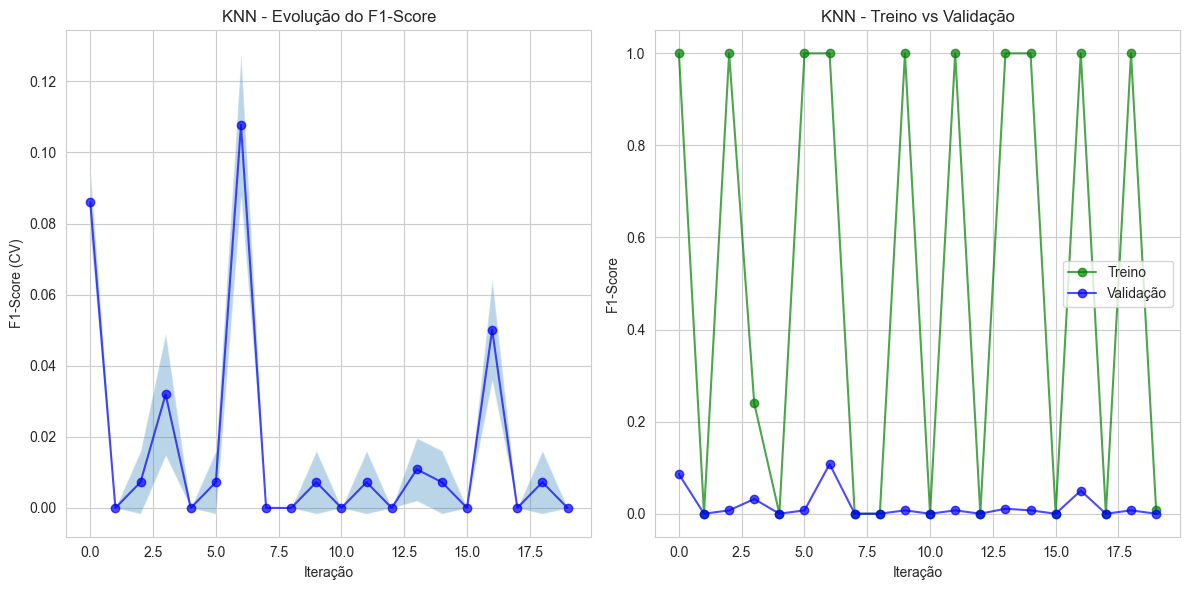

### Train final model and save code variable

In [6]:
# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
# KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

# Armazenar resultados


knn_results = {
    'model': best_knn,
    'search': knn_search,
    'best_params': knn_search.best_params_,
    'best_cv_score': knn_search.best_score_
}

# knn_search = None
# knn_results = {
#     'model': best_knn,
#     'search': knn_search,
#     'best_params': best_knn.get_params(),
#     'best_cv_score': 0.1077
# }

best_knn.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final KNN treinado com dataset completo: {best_knn}")


Modelo final KNN treinado com dataset completo: KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')


## 5. LVQ - Busca de Hiperparâmetros 
Amostra de 2.5%; Random State = 42 para modelo e busca

### Define LVQ

In [ ]:
# ======================================================================
# 4.2 LEARNING VECTOR QUANTIZATION (LVQ) - IMPLEMENTAÇÃO E BUSCA
# ======================================================================


# Implementação do LVQ como Estimador compatível com scikit-learn
from sklearn.base import BaseEstimator, ClassifierMixin

class LVQClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, prototypes_per_class=1, n_epochs=100, learning_rate=0.01, random_state=None):
        """
        prototypes_per_class : int
            Número de protótipos a serem usados para cada classe.
        n_epochs : int
            Número de épocas (iterações completas sobre os dados de treinamento).
        learning_rate : float
            Taxa de aprendizado utilizada para atualizar os protótipos.
        random_state : int ou None
            Semente para reprodutibilidade.
        """
        self.prototypes_per_class = prototypes_per_class
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.random_state = random_state

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        # Determina as classes únicas
        self.classes_ = np.unique(y)
        n_features = X.shape[1]

        # Inicializa os protótipos
        prototypes = []
        prototype_labels = []
        for c in self.classes_:
            X_c = X[y == c]
            # Se a quantidade de exemplos dessa classe for menor que o número de protótipos desejados
            replace_flag = X_c.shape[0] < self.prototypes_per_class
            indices = np.random.choice(X_c.shape[0], size=self.prototypes_per_class, replace=replace_flag)
            prototypes.append(X_c[indices])
            prototype_labels.extend([c] * self.prototypes_per_class)
            
        self.prototypes_ = np.vstack(prototypes)
        self.prototype_labels_ = np.array(prototype_labels)

        # Treinamento – Algoritmo LVQ
        for epoch in range(self.n_epochs):
            # Embaralha os índices dos exemplos
            indices = np.random.permutation(X.shape[0])
            for i in indices:
                xi = X[i]
                yi = y[i]
                # Calcula as distâncias euclidianas do exemplo xi a todos os protótipos
                distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
                # Encontra o índice do protótipo mais próximo
                j = np.argmin(distances)
                # Atualiza o protótipo:
                if self.prototype_labels_[j] == yi:
                    # Se a classe coincide, aproxima o protótipo do exemplo
                    self.prototypes_[j] += self.learning_rate * (xi - self.prototypes_[j])
                else:
                    # Se as classes forem diferentes, afasta o protótipo do exemplo
                    self.prototypes_[j] -= self.learning_rate * (xi - self.prototypes_[j])
        return self

    def predict(self, X):
        X = np.array(X)
        y_pred = []
        # Para cada exemplo, calcula a distância para cada protótipo
        for xi in X:
            distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
            j = np.argmin(distances)
            y_pred.append(self.prototype_labels_[j])
        return np.array(y_pred)

    def predict_proba(self, X):
        """
        Prediz as probabilidades de classe para as amostras em X.
        
        A probabilidade é calculada usando uma função de distância suavizada:
        - Calcula distâncias inversas para cada protótipo
        - Normaliza por classe para obter probabilidades
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Amostras para predizer probabilidades.
            
        Returns
        -------
        probabilities : array, shape (n_samples, n_classes)
            Probabilidades preditas para cada classe.
        """
        X = np.array(X)
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        
        # Inicializa matriz de probabilidades
        probabilities = np.zeros((n_samples, n_classes))
        
        for i, xi in enumerate(X):
            # Calcula distâncias para todos os protótipos
            distances = np.linalg.norm(self.prototypes_ - xi, axis=1)
            
            # Evita divisão por zero adicionando epsilon pequeno
            epsilon = 1e-10
            distances = np.maximum(distances, epsilon)
            
            # Calcula pesos baseados na distância inversa (mais próximo = maior peso)
            weights = 1.0 / distances
            
            # Calcula probabilidades por classe
            for j, class_label in enumerate(self.classes_):
                # Índices dos protótipos desta classe
                class_indices = self.prototype_labels_ == class_label
                
                if np.any(class_indices):
                    # Soma dos pesos dos protótipos desta classe
                    class_weight = np.sum(weights[class_indices])
                    probabilities[i, j] = class_weight
                else:
                    probabilities[i, j] = 0.0
            
            # Normaliza para que a soma seja 1
            total_weight = np.sum(probabilities[i, :])
            if total_weight > 0:
                probabilities[i, :] /= total_weight
            else:
                # Se todos os pesos são zero (caso extremo), atribui probabilidade uniforme
                probabilities[i, :] = 1.0 / n_classes
                
        return probabilities

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

### Search

=== BUSCA DE HIPERPARÂMETROS - LVQ ===
Iniciando busca de hiperparâmetros para LVQ...
Executando 20 buscas com 5 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.1144
Melhor score geral até agora: 0.1144

Busca 2/20...
Melhor score desta busca: 0.1144
Melhor score geral até agora: 0.1144

Busca 2/20...
Melhor score desta busca: 0.1112
Melhor score geral até agora: 0.1144

Busca 3/20...
Melhor score desta busca: 0.1112
Melhor score geral até agora: 0.1144

Busca 3/20...
Melhor score desta busca: 0.0000
Melhor score geral até agora: 0.1144

Busca 4/20...
Melhor score desta busca: 0.0000
Melhor score geral até agora: 0.1144

Busca 4/20...
Melhor score desta busca: 0.1132
Melhor score geral até agora: 0.1144

Busca 5/20...
Melhor score desta busca: 0.1132
Melhor score geral até agora: 0.1144

Busca 5/20...
Melhor score desta busca: 0.0400
Melhor score geral até agora: 0.1144

Busca 6/20...
Melhor score desta busca: 0.0400
Melhor score geral até agora: 0.1144

Busca 6/20...
Melh

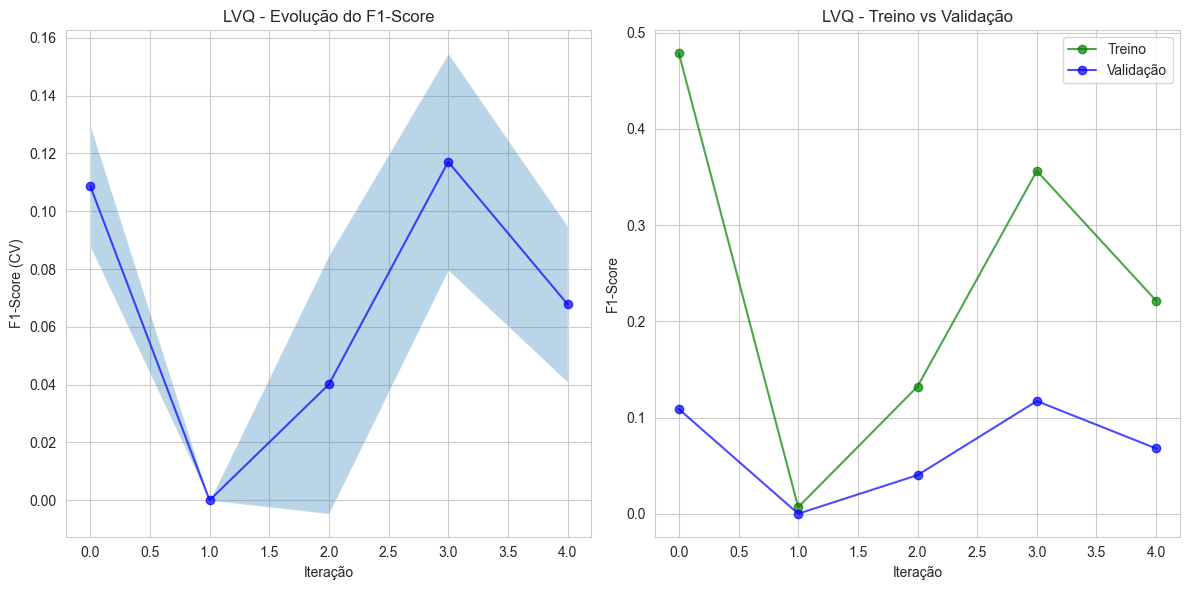

In [ ]:


print("=== BUSCA DE HIPERPARÂMETROS - LVQ ===")

# 4.3 Definição do Espaço de Hiperparâmetros para LVQ
lvq_param_distributions = {
    'prototypes_per_class': randint(1, 100),      # Número de protótipos por classe
    'n_epochs': randint(50, 1000),               # Número de épocas
    'learning_rate': uniform(0.001, 1)       # Taxa de aprendizado
}

# 4.1 Múltiplas execuções do RandomizedSearchCV
print("Iniciando busca de hiperparâmetros para LVQ...")
lvq_search, lvq_all_searches = multiple_randomized_search(
    estimator=LVQClassifier(random_state=42),
    param_distributions=lvq_param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=5,        
    scoring='f1',
    random_state=None,
    n_jobs=-1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS LVQ ---")
print("Melhores hiperparâmetros:")
for param, value in lvq_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {lvq_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(lvq_search, "LVQ")

### Save Outputs for best model and CV results

#### Verbose


Modelo final LVQ treinado com dataset completo: LVQClassifier(learning_rate=np.float64(0.002749027093115263), n_epochs=131,
              prototypes_per_class=5)

=== BUSCA DE HIPERPARÂMETROS - LVQ ===
Iniciando busca de hiperparâmetros para LVQ...
Executando 20 buscas com 4 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0034
Melhor score geral até agora: 0.0034

Busca 2/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0071

Busca 3/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0071

Busca 4/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0071

Busca 5/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0071

Busca 6/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0071

Busca 7/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0071

Busca 8/20...
Melhor score desta busca: 0.0136
Melhor score geral até agora: 0.0170

Busca 9/20...
Melhor score desta busca: 0.0136
Melhor score geral até agora: 0.0170

Busca 10/20...
Melhor score desta busca: 0.0034
Melhor score geral até agora: 0.0170

Busca 11/20...
Melhor score desta busca: 0.0034
Melhor score geral até agora: 0.0170

Busca 12/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0170

Busca 13/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0170

Busca 14/20...
Melhor score desta busca: 0.0134
Melhor score geral até agora: 0.0170

Busca 15/20...
Melhor score desta busca: 0.0134
Melhor score geral até agora: 0.0170

Busca 16/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0170

Busca 17/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0170

Busca 18/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0170

Busca 19/20...
Melhor score desta busca: 0.0071
Melhor score geral até agora: 0.0170

Busca 20/20...
Melhor score desta busca: 0.0034
Melhor score geral até agora: 0.0170

🎯 Busca completa! Melhor score geral: 0.0170
Total de configurações testadas: 80

--- RESULTADOS LVQ ---
Melhores hiperparâmetros:
  learning_rate: 0.002749027093115263
  n_epochs: 131
  prototypes_per_class: 5

Melhor F1-Score (CV): 0.0170
Melhor score desta busca: 0.0034
Melhor score geral até agora: 0.0170

#### Plot

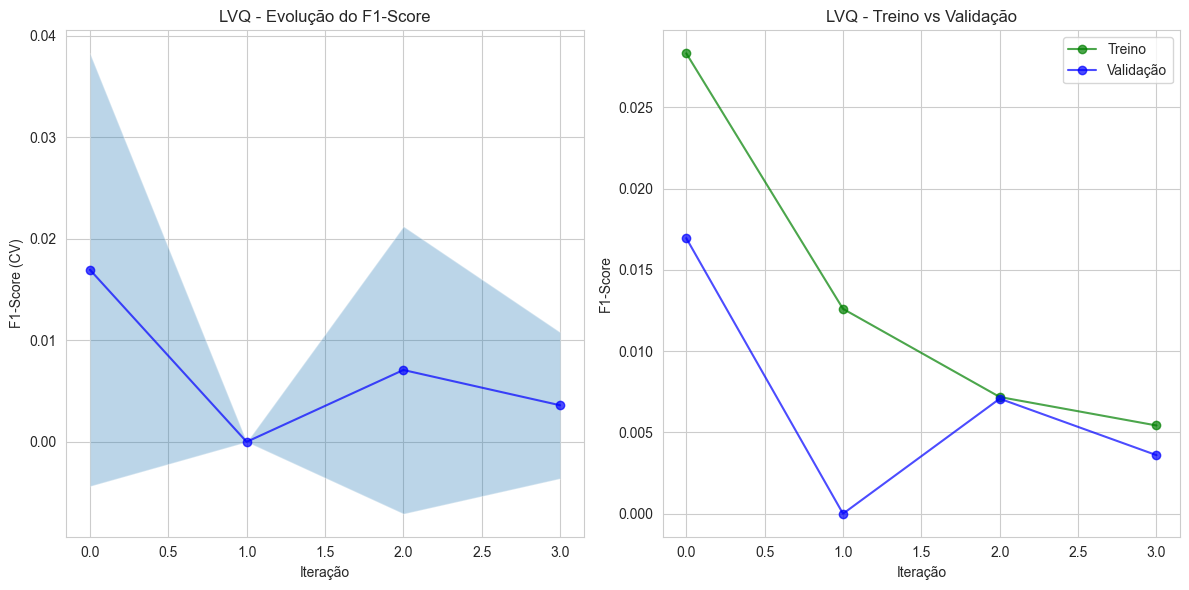

### Train final model and save code variable 

In [109]:
# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
# LVQClassifier(learning_rate=np.float64(0.002749027093115263), n_epochs=131, prototypes_per_class=5)

best_lvq = LVQClassifier(**lvq_search.best_params_)
# best_lvq = LVQClassifier(learning_rate=np.float64(0.002749027093115263), n_epochs=131, prototypes_per_class=5)

# Armazenar resultados
# lvq_results = {
#     'model': best_lvq,
#     'search': lvq_search,
#     'best_params': lvq_search.best_params_,
#     'best_cv_score': lvq_search.best_score_
# }

lvq_search = None
lvq_results = {
    'model': best_lvq,
    'search': lvq_search,
    'best_params': best_lvq.get_params(),
    'best_cv_score': 0.1171
}

In [110]:
_, X_sample2, _, y_sample2 = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.5,  
    stratify=y_train,
    random_state=10
)

best_lvq.fit(X_sample2, y_sample2)  # Treino com dataset completo

# best_lvq.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final LVQ treinado com dataset completo: {best_lvq}")

,prototypes_per_class,5
,n_epochs,131
,learning_rate,np.float64(0....9027093115263)
,random_state,None


## 6. SVM - Busca de Hiperparâmetros
Amostra de 0.1%; Random state = 10 para modelo e RandomState = 42 para busca

### Search

=== BUSCA DE HIPERPARÂMETROS - SVM ===
Iniciando busca de hiperparâmetros para SVM...
Executando 20 buscas com 5 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.0625

Busca 2/20...
Melhor score desta busca: 0.1476
Melhor score geral até agora: 0.1476

Busca 3/20...
Melhor score desta busca: 0.0500
Melhor score geral até agora: 0.1476

Busca 4/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1476

Busca 5/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1476

Busca 6/20...
Melhor score desta busca: 0.1451
Melhor score geral até agora: 0.1476

Busca 7/20...
Melhor score desta busca: 0.0841
Melhor score geral até agora: 0.1476

Busca 8/20...
Melhor score desta busca: 0.0897
Melhor score geral até agora: 0.1476

Busca 9/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1476

Busca 10/20...
Melhor score desta busca: 0.0000
Melhor score geral até agora: 0.1476

Busca 11/20...
Me

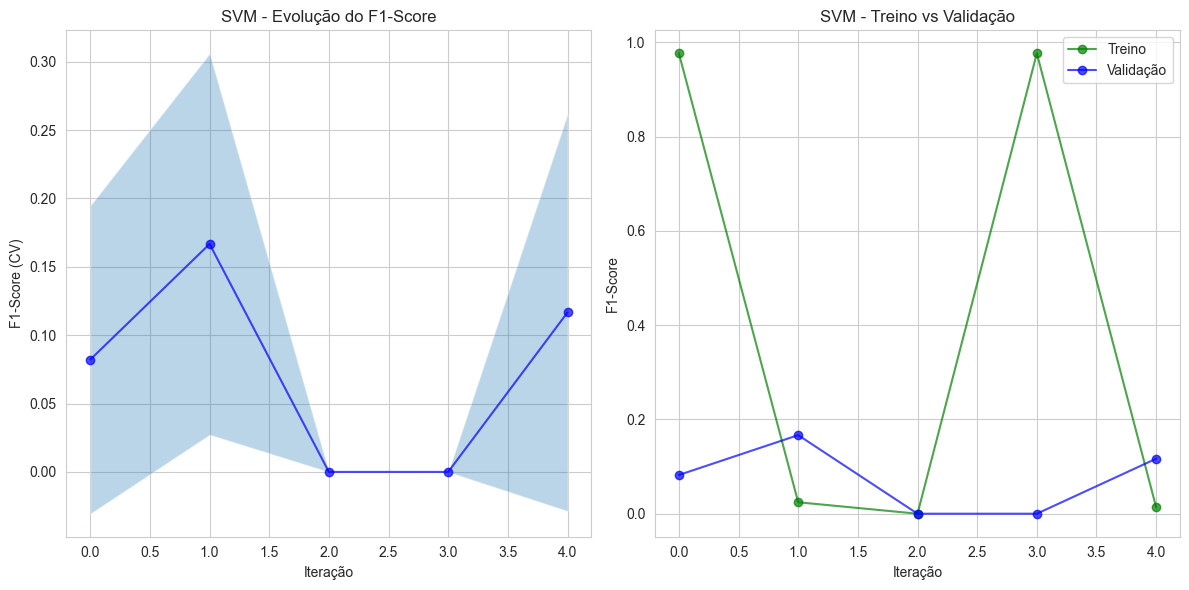

In [60]:
# ======================================================================
# 4.2 SUPPORT VECTOR MACHINE (SVM) - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - SVM ===")

# 4.3 Definição do Espaço de Hiperparâmetros para SVM
svm_param_distributions = {
    'C': uniform(0.1, 1000),                    # Distribuição log-uniforme para C
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],       # Tipos de kernel
    'gamma': ['scale', 'auto'] + list(uniform(0.01, 100).rvs(10))  # Parâmetro gamma
}

# 4.1 Múltiplas execuções do RandomizedSearchCV
print("Iniciando busca de hiperparâmetros para SVM...")
svm_search, svm_all_searches = multiple_randomized_search(
    estimator=SVC(random_state=10),
    param_distributions=svm_param_distributions,
    X=X_sample,                   
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=5,         
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS SVM ---")
print("Melhores hiperparâmetros:")
for param, value in svm_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {svm_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(svm_search, "SVM")

### Save outputs for best model and CV results

=== BUSCA DE HIPERPARÂMETROS - SVM ===
Iniciando busca de hiperparâmetros para SVM...
Executando 20 buscas com 4 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0500
Melhor score geral até agora: 0.0500

Busca 2/20...
Melhor score desta busca: 0.1451
Melhor score geral até agora: 0.1451

Busca 3/20...
Melhor score desta busca: 0.1030
Melhor score geral até agora: 0.1451

Busca 4/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1451

Busca 5/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 6/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 7/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1451

Busca 8/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 9/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1451

Busca 10/20...
Melhor score desta busca: 0.0882
Melhor score geral até agora: 0.1451

Busca 11/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 12/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 13/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1451

Busca 14/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 15/20...
Melhor score desta busca: 0.1451
Melhor score geral até agora: 0.1451

Busca 16/20...
Melhor score desta busca: 0.0364
Melhor score geral até agora: 0.1451

Busca 17/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1451

Busca 18/20...
Melhor score desta busca: 0.1071
Melhor score geral até agora: 0.1451

Busca 19/20...
Melhor score desta busca: 0.0625
Melhor score geral até agora: 0.1451

Busca 20/20...
Melhor score desta busca: 0.1602
Melhor score geral até agora: 0.1602

🎯 Busca completa! Melhor score geral: 0.1602
Total de configurações testadas: 80

--- RESULTADOS SVM ---
Melhores hiperparâmetros:
  C: 849.0051076148221
  gamma: auto
  kernel: sigmoid

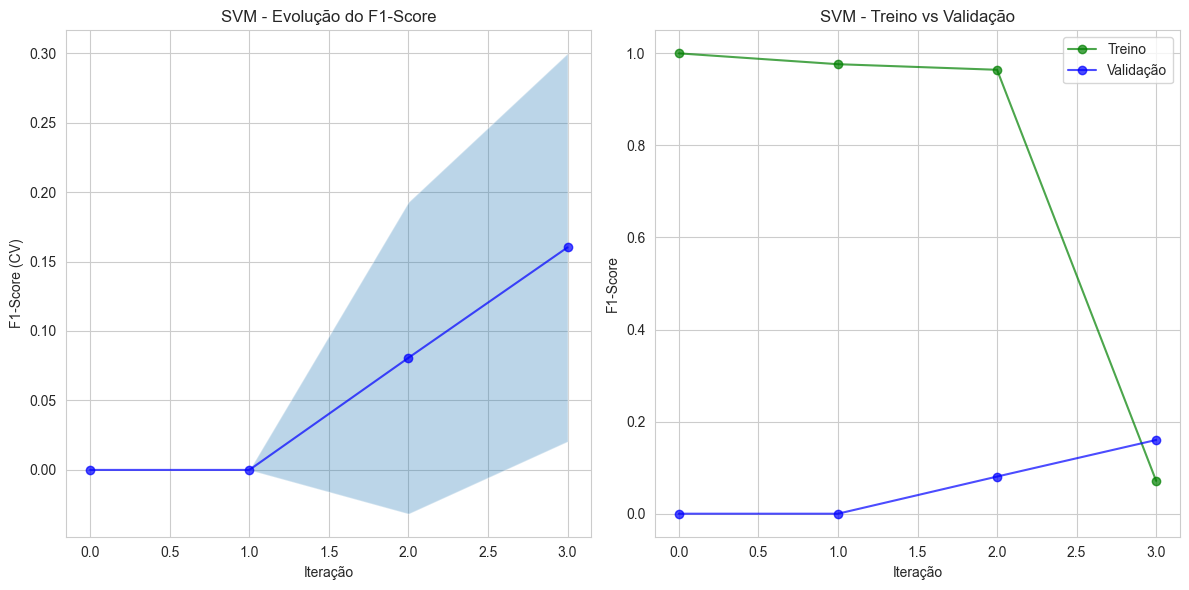

### Train final model and save code variable

In [151]:
# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
# --- RESULTADOS SVM ---
# Melhores hiperparâmetros:
#   C: 849.0051076148221
#   gamma: auto
#   kernel: sigmoid

# Melhores hiperparâmetros:
#   C: 413.1003988473893
#   gamma: 18.059431965634634
#   kernel: sigmoid
# best_svm = SVC(C=413.1003988473893, gamma=18.059431965634634, kernel='sigmoid', probability=True)
best_svm = SVC(C=849.0051076148221, gamma='auto', kernel='sigmoid', probability=True)
# best_svm = SVC(**svm_search.best_params_, probability=True)

# Armazenar resultados
svm_results = {
    'model': best_svm,
    'search': svm_search,
    'best_params': svm_search.best_params_ if svm_search else best_svm.get_params(),
    'best_cv_score': svm_search.best_score_
}


# svm_results = {
#     'model': best_svm,
#     'search': svm_search,
#     'best_params': best_svm.get_params(),
#     'best_cv_score': 0.1667
# }


In [152]:
_, X_sample2, _, y_sample2 = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.10,  
    stratify=y_train,
    random_state=10
)

best_svm.fit(X_sample2, y_sample2)  # Treino com dataset completo

# best_svm.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final SVM treinado com dataset completo: {best_svm}")


Modelo final SVM treinado com dataset completo: SVC(C=849.0051076148221, gamma='auto', kernel='sigmoid', probability=True)


## 7. Decision Tree - Busca de Hiperparâmetros

Amostra de 10% ; Random State = 42 para busca e modelo

=== BUSCA DE HIPERPARÂMETROS - DECISION TREE ===
Iniciando busca de hiperparâmetros para Decision Tree...
Executando 20 buscas com 20 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0855
Melhor score geral até agora: 0.0855

Busca 2/20...
Melhor score desta busca: 0.0855
Melhor score geral até agora: 0.0855

Busca 2/20...
Melhor score desta busca: 0.0521
Melhor score geral até agora: 0.0855

Busca 3/20...
Melhor score desta busca: 0.0521
Melhor score geral até agora: 0.0855

Busca 3/20...
Melhor score desta busca: 0.0937
Melhor score geral até agora: 0.0937

Busca 4/20...
Melhor score desta busca: 0.0937
Melhor score geral até agora: 0.0937

Busca 4/20...
Melhor score desta busca: 0.0905
Melhor score geral até agora: 0.0937

Busca 5/20...
Melhor score desta busca: 0.0905
Melhor score geral até agora: 0.0937

Busca 5/20...
Melhor score desta busca: 0.0671
Melhor score geral até agora: 0.0937

Busca 6/20...
Melhor score desta busca: 0.0671
Melhor score geral até agora: 0.093

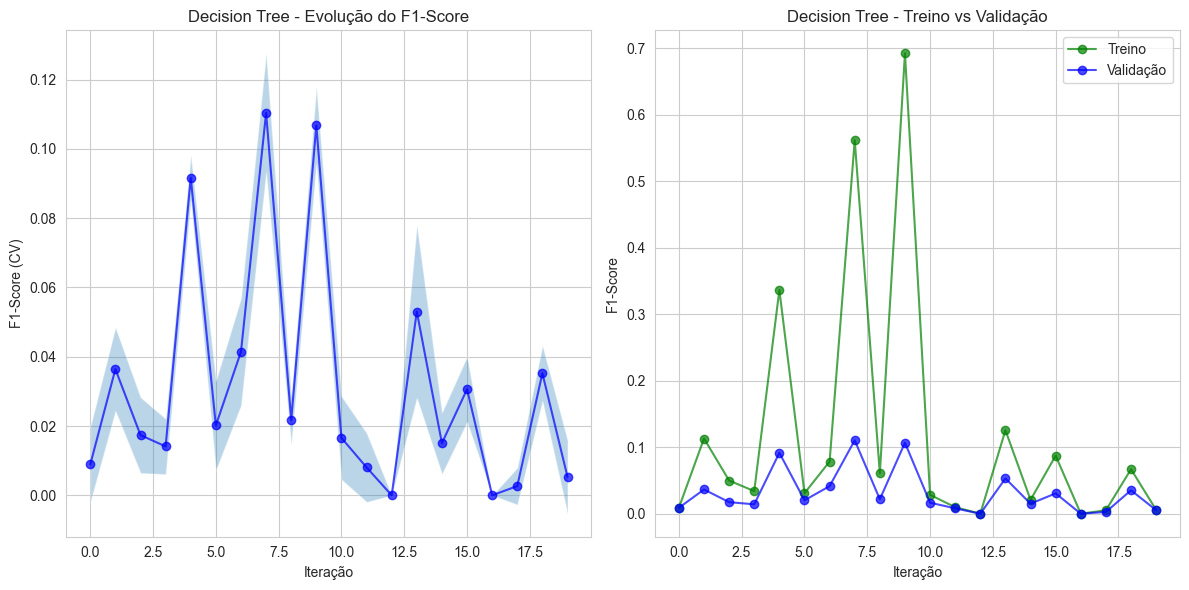

In [22]:
# ======================================================================
# 4.4 DECISION TREE - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - DECISION TREE ===")

# 4.3 Definição do Espaço de Hiperparâmetros para Decision Tree
dt_param_distributions = {
    'max_depth': randint(3, 50),                    # Profundidade máxima
    'min_samples_split': randint(2, 40),            # Mínimo de amostras para dividir
    'min_samples_leaf': randint(1, 50),             # Mínimo de amostras por folha
    'criterion': ['gini', 'entropy'],               # Critério de divisão
    'max_features': ['sqrt', 'log2', None]          # Número máximo de features
}

# 4.1 Múltiplas execuções do RandomizedSearchCV 
print("Iniciando busca de hiperparâmetros para Decision Tree...")
dt_search, dt_all_searches = multiple_randomized_search(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_distributions,
    X=X_sample,                   
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=20,         
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS DECISION TREE ---")
print("Melhores hiperparâmetros:")
for param, value in dt_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {dt_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(dt_search, "Decision Tree")

### Save outputs for best model and CV results

#### Verbose

Modelo final Decision Tree treinado com dataset completo: DecisionTreeClassifier(criterion='entropy', max_depth=38, min_samples_leaf=3,
                       min_samples_split=14)

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 85,301 amostras
Redução: 90.0%

Distribuição das classes na amostra:
Amostra: {0.0: 83112, 1.0: 2189}
Original: {0.0: 831112, 1.0: 21894}
Dataset original de treino: 853,006 amostras
Amostra para busca de hiperparâmetros: 85,301 amostras
Redução: 90.0%

Distribuição das classes na amostra:
Amostra: {0.0: 83112, 1.0: 2189}
Original: {0.0: 831112, 1.0: 21894}
=== BUSCA DE HIPERPARÂMETROS - KNN ===
Iniciando busca de hiperparâmetros para KNN...
Executando 20 buscas com 20 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0722

Busca 2/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0722

Busca 2/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 3/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 3/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 4/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 4/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 5/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 5/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 6/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 6/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 7/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 7/20...
Melhor score desta busca: 0.0440
Melhor score geral até agora: 0.0772

Busca 8/20...
Melhor score desta busca: 0.0440
Melhor score geral até agora: 0.0772

Busca 8/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 9/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 9/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 10/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 10/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 11/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 11/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 12/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 12/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0772

Busca 13/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0772

Busca 13/20...
Melhor score desta busca: 0.0176
Melhor score geral até agora: 0.0772

Busca 14/20...
Melhor score desta busca: 0.0176
Melhor score geral até agora: 0.0772

Busca 14/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 15/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 15/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 16/20...
Melhor score desta busca: 0.0722
Melhor score geral até agora: 0.0772

Busca 16/20...
Melhor score desta busca: 0.0438
Melhor score geral até agora: 0.0772

Busca 17/20...
Melhor score desta busca: 0.0438
Melhor score geral até agora: 0.0772

Busca 17/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 18/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 18/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 19/20...
Melhor score desta busca: 0.0772
Melhor score geral até agora: 0.0772

Busca 19/20...
Melhor score desta busca: 0.0403
Melhor score geral até agora: 0.0772

Busca 20/20...
Melhor score desta busca: 0.0403
Melhor score geral até agora: 0.0772

Busca 20/20...
Melhor score desta busca: 0.0440
Melhor score geral até agora: 0.0772

🎯 Busca completa! Melhor score geral: 0.0772
Total de configurações testadas: 400

--- RESULTADOS KNN ---
Melhores hiperparâmetros:
  metric: manhattan
  n_neighbors: 2
  weights: distance

Melhor F1-Score (CV): 0.0772
Melhor score desta busca: 0.0440
Melhor score geral até agora: 0.0772

🎯 Busca completa! Melhor score geral: 0.0772
Total de configurações testadas: 400

--- RESULTADOS KNN ---
Melhores hiperparâmetros:
  metric: manhattan
  n_neighbors: 2
  weights: distance

Melhor F1-Score (CV): 0.0772

Modelo final KNN treinado com dataset completo: KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

Modelo final KNN treinado com dataset completo: KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

=== BUSCA DE HIPERPARÂMETROS - DECISION TREE ===
Iniciando busca de hiperparâmetros para Decision Tree...
Executando 20 buscas com 20 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0855
Melhor score geral até agora: 0.0855

Busca 2/20...
Melhor score desta busca: 0.0855
Melhor score geral até agora: 0.0855

Busca 2/20...
Melhor score desta busca: 0.0521
Melhor score geral até agora: 0.0855

Busca 3/20...
Melhor score desta busca: 0.0521
Melhor score geral até agora: 0.0855

Busca 3/20...
Melhor score desta busca: 0.0937
Melhor score geral até agora: 0.0937

Busca 4/20...
Melhor score desta busca: 0.0937
Melhor score geral até agora: 0.0937

Busca 4/20...
Melhor score desta busca: 0.0905
Melhor score geral até agora: 0.0937

Busca 5/20...
Melhor score desta busca: 0.0905
Melhor score geral até agora: 0.0937

Busca 5/20...
Melhor score desta busca: 0.0671
Melhor score geral até agora: 0.0937

Busca 6/20...
Melhor score desta busca: 0.0671
Melhor score geral até agora: 0.0937

Busca 6/20...
Melhor score desta busca: 0.0743
Melhor score geral até agora: 0.0937

Busca 7/20...
Melhor score desta busca: 0.0743
Melhor score geral até agora: 0.0937

Busca 7/20...
Melhor score desta busca: 0.0891
Melhor score geral até agora: 0.0937

Busca 8/20...
Melhor score desta busca: 0.0891
Melhor score geral até agora: 0.0937

Busca 8/20...
Melhor score desta busca: 0.0668
Melhor score geral até agora: 0.0937

Busca 9/20...
Melhor score desta busca: 0.0668
Melhor score geral até agora: 0.0937

Busca 9/20...
Melhor score desta busca: 0.1104
Melhor score geral até agora: 0.1104

Busca 10/20...
Melhor score desta busca: 0.1104
Melhor score geral até agora: 0.1104

Busca 10/20...
Melhor score desta busca: 0.1013
Melhor score geral até agora: 0.1104

Busca 11/20...
Melhor score desta busca: 0.1013
Melhor score geral até agora: 0.1104

Busca 11/20...
Melhor score desta busca: 0.0860
Melhor score geral até agora: 0.1104

Busca 12/20...
Melhor score desta busca: 0.0860
Melhor score geral até agora: 0.1104

Busca 12/20...
Melhor score desta busca: 0.0846
Melhor score geral até agora: 0.1104

Busca 13/20...
Melhor score desta busca: 0.0846
Melhor score geral até agora: 0.1104

Busca 13/20...
Melhor score desta busca: 0.0440
Melhor score geral até agora: 0.1104

Busca 14/20...
Melhor score desta busca: 0.0440
Melhor score geral até agora: 0.1104

Busca 14/20...
Melhor score desta busca: 0.0899
Melhor score geral até agora: 0.1104

Busca 15/20...
Melhor score desta busca: 0.0899
Melhor score geral até agora: 0.1104

Busca 15/20...
Melhor score desta busca: 0.0915
Melhor score geral até agora: 0.1104

Busca 16/20...
Melhor score desta busca: 0.0915
Melhor score geral até agora: 0.1104

Busca 16/20...
Melhor score desta busca: 0.0668
Melhor score geral até agora: 0.1104

Busca 17/20...
Melhor score desta busca: 0.0668
Melhor score geral até agora: 0.1104

Busca 17/20...
Melhor score desta busca: 0.0833
Melhor score geral até agora: 0.1104

Busca 18/20...
Melhor score desta busca: 0.0833
Melhor score geral até agora: 0.1104

Busca 18/20...
Melhor score desta busca: 0.1037
Melhor score geral até agora: 0.1104

Busca 19/20...
Melhor score desta busca: 0.1037
Melhor score geral até agora: 0.1104

Busca 19/20...
Melhor score desta busca: 0.0814
Melhor score geral até agora: 0.1104

Busca 20/20...
Melhor score desta busca: 0.0814
Melhor score geral até agora: 0.1104

Busca 20/20...
Melhor score desta busca: 0.0849
Melhor score geral até agora: 0.1104

🎯 Busca completa! Melhor score geral: 0.1104
Total de configurações testadas: 400

--- RESULTADOS DECISION TREE ---
Melhores hiperparâmetros:
  criterion: entropy
  max_depth: 38
  max_features: None
  min_samples_leaf: 3
  min_samples_split: 14

Melhor F1-Score (CV): 0.1104
Melhor score desta busca: 0.0849
Melhor score geral até agora: 0.1104

🎯 Busca completa! Melhor score geral: 0.1104
Total de configurações testadas: 400

--- RESULTADOS DECISION TREE ---
Melhores hiperparâmetros:
  criterion: entropy
  max_depth: 38
  max_features: None
  min_samples_leaf: 3
  min_samples_split: 14

Melhor F1-Score (CV): 0.1104

#### Plot

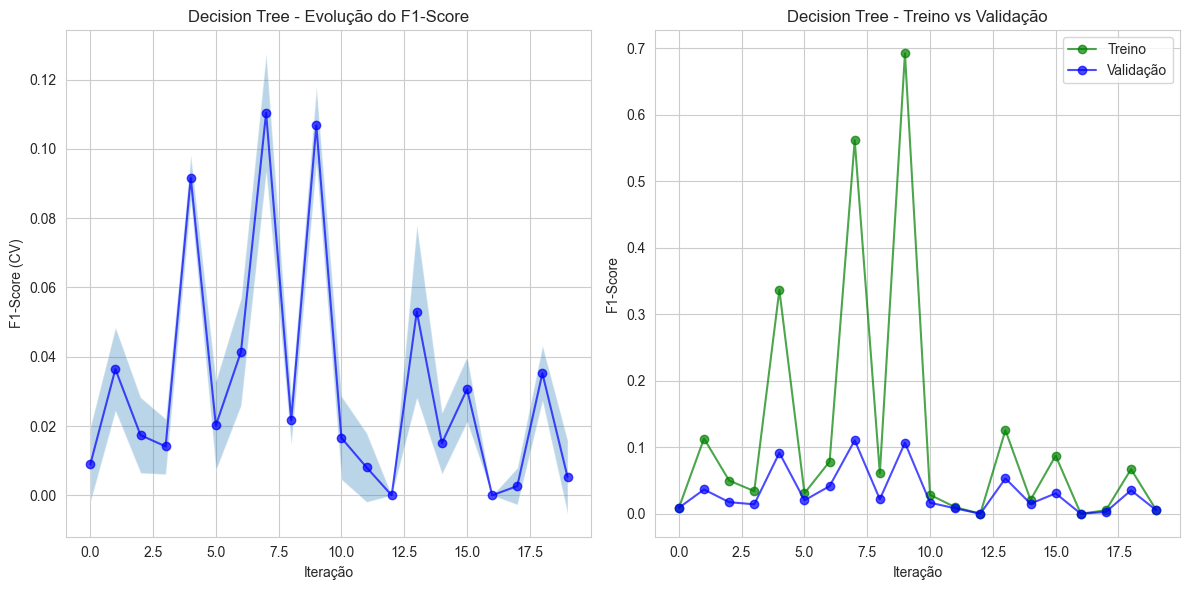

### Train final model and save code variable

In [31]:

# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_dt = DecisionTreeClassifier(criterion='entropy', max_depth=38, min_samples_leaf=3, min_samples_split=14)
# best_dt = DecisionTreeClassifier(**dt_search.best_params_)

# Armazenar resultados
dt_results = {
    'model': best_dt,
    'search': dt_search,
    'best_params': dt_search.best_params_,
    'best_cv_score': dt_search.best_score_
}

# dt_results = {
#     'model': best_dt,
#     'search': dt_search,
#     'best_params': best_dt.get_params(),
#     'best_cv_score': 0.1104
# }

In [32]:
# _, X_sample2, _, y_sample2 = train_test_split(
#     X_train_scaled, y_train, 
#     test_size=0.7,  
#     stratify=y_train,
#     random_state=10
# )

# best_dt.fit(X_sample2, y_sample2)  # Treino com dataset completo
best_dt.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final Decision Tree treinado com dataset completo: {best_dt}")


Modelo final Decision Tree treinado com dataset completo: DecisionTreeClassifier(criterion='entropy', max_depth=38, min_samples_leaf=3,
                       min_samples_split=14)


## 8. Random Forest - Busca de Hiperparâmetros
Amostra de 1% ; RandomState = 42 para busca e modelo

=== BUSCA DE HIPERPARÂMETROS - RANDOM FOREST ===
Iniciando busca de hiperparâmetros para Random Forest...
Executando 20 buscas com 20 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0261

Busca 2/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0261

Busca 2/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0261

Busca 3/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0261

Busca 3/20...
Melhor score desta busca: 0.0263
Melhor score geral até agora: 0.0263

Busca 4/20...
Melhor score desta busca: 0.0263
Melhor score geral até agora: 0.0263

Busca 4/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0263

Busca 5/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0263

Busca 5/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0263

Busca 6/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.026

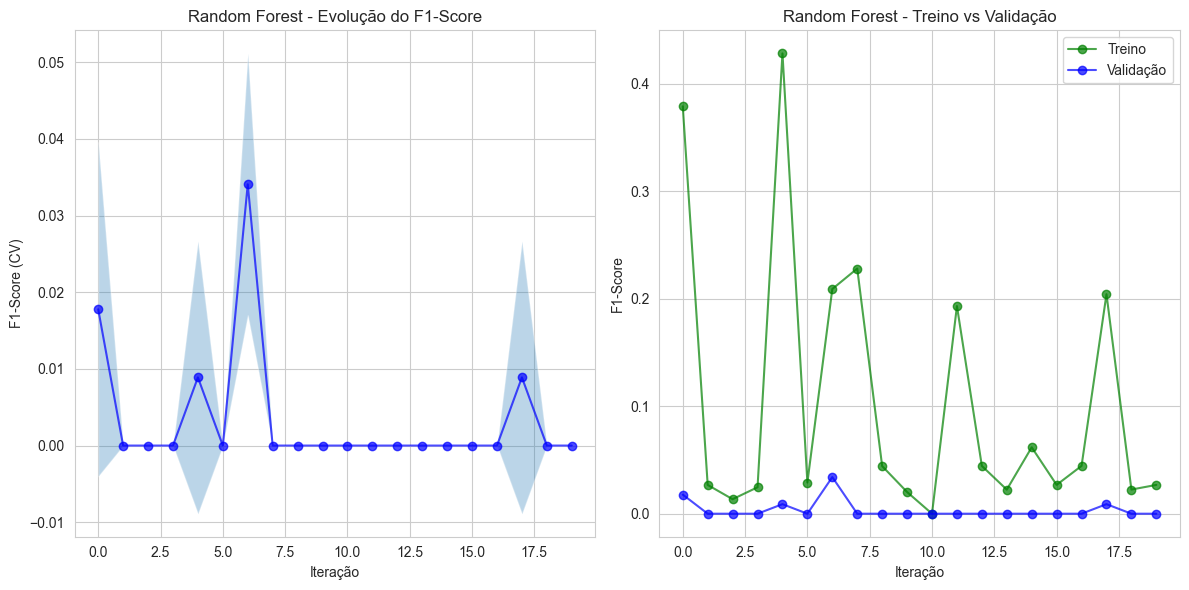

In [ ]:
# ======================================================================
# 4.3 RANDOM FOREST - BUSCA DE HIPERPARAMETROS
# ======================================================================

print("=== BUSCA DE HIPERPARÂMETROS - RANDOM FOREST ===")

# 4.3 Definição do Espaço de Hiperparâmetros para Random Forest
rf_param_distributions = {
    'n_estimators': randint(5, 300),           # Número de árvores 
    'max_depth': randint(3, 50),                # Profundidade máxima
    'min_samples_split': randint(2, 20),        # Mínimo de amostras para dividir
    'min_samples_leaf': randint(1, 10),         # Mínimo de amostras por folha
}

# 4.1 Múltiplas execuções do RandomizedSearchCV
print("Iniciando busca de hiperparâmetros para Random Forest...")
rf_search, rf_all_searches = multiple_randomized_search(
    estimator=RandomForestClassifier(random_state=42, criterion='gini', max_features='sqrt'),
    param_distributions=rf_param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,               
    n_iter_per_search=20,         
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# 5.1 Seleção da Melhor Configuração
print("\n--- RESULTADOS RANDOM FOREST ---")
print("Melhores hiperparâmetros:")
for param, value in rf_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {rf_search.best_score_:.4f}")

# 4.4 Registro de Desempenho - plotar evolução
plot_search_history(rf_search, "Random Forest")

### Save Output for best model and CV results

=== BUSCA DE HIPERPARÂMETROS - RANDOM FOREST ===
Iniciando busca de hiperparâmetros para Random Forest...
Executando 20 buscas com 20 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0261

Busca 2/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0261

Busca 2/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0261

Busca 3/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0261

Busca 3/20...
Melhor score desta busca: 0.0263
Melhor score geral até agora: 0.0263

Busca 4/20...
Melhor score desta busca: 0.0263
Melhor score geral até agora: 0.0263

Busca 4/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0263

Busca 5/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0263

Busca 5/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0263

Busca 6/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0263

Busca 6/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0263

Busca 7/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0263

Busca 7/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0263

Busca 8/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0263

Busca 8/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0263

Busca 9/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0263

Busca 9/20...
Melhor score desta busca: 0.0341
Melhor score geral até agora: 0.0341

Busca 10/20...
Melhor score desta busca: 0.0341
Melhor score geral até agora: 0.0341

Busca 10/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 11/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 11/20...
Melhor score desta busca: 0.0178
Melhor score geral até agora: 0.0341

Busca 12/20...
Melhor score desta busca: 0.0178
Melhor score geral até agora: 0.0341

Busca 12/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 13/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 13/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 14/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 14/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 15/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 15/20...
Melhor score desta busca: 0.0263
Melhor score geral até agora: 0.0341

Busca 16/20...
Melhor score desta busca: 0.0263
Melhor score geral até agora: 0.0341

Busca 16/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0341

Busca 17/20...
Melhor score desta busca: 0.0174
Melhor score geral até agora: 0.0341

Busca 17/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 18/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 18/20...
Melhor score desta busca: 0.0178
Melhor score geral até agora: 0.0341

Busca 19/20...
Melhor score desta busca: 0.0178
Melhor score geral até agora: 0.0341

Busca 19/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 20/20...
Melhor score desta busca: 0.0089
Melhor score geral até agora: 0.0341

Busca 20/20...
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0341

🎯 Busca completa! Melhor score geral: 0.0341
Total de configurações testadas: 400

--- RESULTADOS RANDOM FOREST ---
Melhores hiperparâmetros:
  max_depth: 13
  min_samples_leaf: 1
  min_samples_split: 16
  n_estimators: 10

Melhor F1-Score (CV): 0.0341
Melhor score desta busca: 0.0261
Melhor score geral até agora: 0.0341

🎯 Busca completa! Melhor score geral: 0.0341
Total de configurações testadas: 400

--- RESULTADOS RANDOM FOREST ---
Melhores hiperparâmetros:
  max_depth: 13
  min_samples_leaf: 1
  min_samples_split: 16
  n_estimators: 10

Melhor F1-Score (CV): 0.0341

### Train final model and save code variable

In [41]:
# 5.2 Treinamento Final com dataset completo usando melhores hiperparâmetros
best_rf = RandomForestClassifier(**rf_search.best_params_)

# Armazenar resultados
rf_results = {
    'model': best_rf,
    'search': rf_search,
    'best_params': rf_search.best_params_,
    'best_cv_score': rf_search.best_score_
}

In [42]:
# _, X_sample2, _, y_sample2 = train_test_split(
#     X_train_scaled, y_train, 
#     test_size=0.1,  
#     stratify=y_train,
#     random_state=42
# )

# best_rf.fit(X_sample2, y_sample2)  # Treino com dataset completo
best_rf.fit(X_train_scaled, y_train)  # Treino com dataset completo
print(f"\nModelo final Random Forest treinado com dataset completo: {best_rf}")


Modelo final Random Forest treinado com dataset completo: RandomForestClassifier(max_depth=13, min_samples_split=16, n_estimators=10)


## 8.B Save All Trained Models 
Run if needed 

In [23]:
import os
from joblib import dump, load

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar todos os modelos treinados
models_to_save = {
    # 'KNN': best_knn,
    'LVQ': best_lvq, 
    # 'SVM': best_svm,
    # 'Decision_Tree': best_dt,
    # 'Random_Forest': best_rf
}

print("=== SALVANDO MODELOS TREINADOS ===")
for model_name, model in models_to_save.items():

    filename = f'models/{model_name.lower()}_trained.joblib'
    dump(model, filename)
    print(f"✅ {model_name} salvo em: {filename}")

# Salvar também o scaler
dump(scaler, 'models/scaler.joblib')
print("✅ Scaler salvo em: models/scaler.joblib")

=== SALVANDO MODELOS TREINADOS ===
✅ LVQ salvo em: models/lvq_trained.joblib
✅ Scaler salvo em: models/scaler.joblib


## 9. Monitoramento e Avaliação dos Modelos

### 9.1 Recuperar Modelos e Resultados das Buscas Randomizadas

#### 9.1.1 Busca

In [ ]:
# ======================================================================
# RECUPERAÇÃO DOS RESULTADOS DE BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== CARREGANDO RESULTADOS DE BUSCA SALVOS ===")

import os

def load_search_results(search_folder='searches'):
    """Carrega os resultados de busca salvos em CSV"""
    search_results = {}
    
    if not os.path.exists(search_folder):
        print(f"❌ Pasta {search_folder} não encontrada!")
        return search_results
    
    # Mapear arquivos para modelos
    file_mapping = {
        'knn_all_searches.csv': 'KNN',
        'dt_all_searches.csv': 'Decision Tree', 
        'rf_all_searches.csv': 'Random Forest',
        'svm_all_searches.csv': 'SVM',
        'lvq_all_searches.csv': 'LVQ'
    }
    
    for filename, model_name in file_mapping.items():
        filepath = os.path.join(search_folder, filename)
        
        if os.path.exists(filepath):
            try:
                df = pd.read_csv(filepath)
                search_results[model_name] = df
                print(f"✅ {model_name}: {len(df)} configurações carregadas")
            except Exception as e:
                print(f"❌ Erro ao carregar {filename}: {e}")
        else:
            print(f"⚠️  Arquivo não encontrado: {filename}")
    
    return search_results

# Carregar resultados
all_search_results = load_search_results()

# Exemplo de como acessar os dados
if 'KNN' in all_search_results:
    knn_searches = all_search_results['KNN']
    print(f"\nExemplo - KNN: {len(knn_searches)} configurações testadas")
    print("Colunas disponíveis:", list(knn_searches.columns))
    
    # Ver melhores resultados
    if 'best_score' in knn_searches.columns:
        best_knn_config = knn_searches.loc[knn_searches['best_score'].idxmax()]
        print(f"Melhor configuração KNN: Score = {best_knn_config['best_score']:.4f}")

In [ ]:
# ======================================================================
# CRIAÇÃO DOS MODELOS COM OS MELHORES PARÂMETROS ENCONTRADOS
# ======================================================================

print("=== CRIANDO MODELOS COM MELHORES PARÂMETROS ===")

def create_best_models(best_results):
    """Cria instâncias dos modelos com os melhores parâmetros"""
    best_models = {}
    
    for model_name, results in best_results.items():
        best_params = results['best_params']
        cv_score = results['best_score']
        
        print(f"\n--- Criando {model_name} ---")
        print(f"F1-Score CV: {cv_score:.4f}")
        print("Parâmetros:", best_params)
        
        try:
            if model_name == 'KNN':
                model = KNeighborsClassifier(**best_params)
            elif model_name == 'SVM':
                model = SVC(**best_params, probability=True)  # Adicionar probability para ROC
            elif model_name == 'Random Forest':
                model = RandomForestClassifier(**best_params, random_state=42)
            elif model_name == 'Decision Tree':
                model = DecisionTreeClassifier(**best_params, random_state=42)
            elif model_name == 'LVQ':
                model = LVQClassifier(**best_params)
            else:
                print(f"⚠️  Modelo {model_name} não reconhecido")
                continue
            
            best_models[model_name] = {
                'model': model,
                'best_params': best_params,
                'cv_score': cv_score,
                'std_score': results.get('std_test_score', 0.0)
            }
            print(f"✅ {model_name} criado com sucesso")
            
        except Exception as e:
            print(f"❌ Erro ao criar {model_name}: {e}")
            continue
    
    return best_models

# Criar modelos com melhores parâmetros
if best_model_results:
    optimized_models = create_best_models(best_model_results)
    print(f"\n✅ Total de modelos criados: {len(optimized_models)}")
else:
    print("❌ Nenhum resultado de busca carregado. Execute as buscas primeiro.")
    optimized_models = {}

#### 9.1.2 Modelos

In [ ]:
from joblib import load
import os

def load_trained_models(models_folder='models'):
    """Carrega todos os modelos treinados"""
    trained_models = {}
    
    if not os.path.exists(models_folder):
            print(f"❌ Pasta {models_folder} não encontrada!")
            return trained_models
        
    model_files = {
        'knn_trained.joblib': 'KNN',
        'lvq_trained.joblib': 'LVQ',
        'svm_trained.joblib': 'SVM', 
        'rf_trained.joblib': 'Random Forest',
        'dt_trained.joblib': 'Decision Tree'
    }
    
    for filename, model_name in model_files.items():
        filepath = os.path.join(models_folder, filename)
        
        if os.path.exists(filepath):
            try:
                model = load(filepath)
                trained_models[model_name] = model
                print(f"✅ Modelo {model_name}: Carregado com sucesso")
            except Exception as e:
                print(f"❌ Erro ao carregar modelo {filename}: {e}")
        else:
            print(f"⚠️  Modelo não encontrado: {filename}")
    
    # Carregar scaler se existir
    scaler_path = os.path.join(models_folder, 'scaler.joblib')
    if os.path.exists(scaler_path):
        try:
            trained_models['scaler'] = load(scaler_path)
            print("✅ Scaler: Carregado com sucesso")
        except Exception as e:
            print(f"❌ Erro ao carregar scaler: {e}")
    
    return trained_models

# Usar em outro notebook
trained_models = load_trained_models()
expected_models = ['KNN', 'LVQ', 'SVM', 'Decision Tree', 'Random Forest']
missing_models = [model for model in expected_models if model not in trained_models]

if missing_models:
    print(f"⚠️ Modelos faltando: {missing_models}")

### 9.2 Avaliação no conjunto de teste

In [61]:
# ======================================================================
# 5.3 AVALIAÇÃO NO CONJUNTO DE TESTE
# ======================================================================

print("=== AVALIAÇÃO FINAL DOS MODELOS NO CONJUNTO DE TESTE ===")

# Dicionário para armazenar todos os modelos
models = {
    'KNN': knn_results,
    'LVQ': lvq_results,
    'Random Forest': rf_results,
    'Decision Tree': dt_results,
    'SVM': svm_results,
}

# Dicionário para armazenar resultados finais
final_results = {}

# Amostragem de teste e treino para evitar muito tempo de processamento
_, X_test_sample_final, _, y_test_sample_final = train_test_split(
    X_test_scaled, y_test, 
    test_size=0.5,  
    stratify=y_test,
    random_state=10
)

_, X_train_sample_final, _, y_train_sample_final = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.5,  
    stratify=y_train,
    random_state=10
)


=== AVALIAÇÃO FINAL DOS MODELOS NO CONJUNTO DE TESTE ===


In [157]:
# Avaliar cada modelo (exceto KNN) no conjunto de teste
for model_name, model_info in models.items():
    print(f"\n--- Avaliando {model_name} ---")
    
    model = model_info['model']
    if model_name == 'KNN':
        print("Pulando KNN devido ao tempo de execução elevado.")
        continue
    # 5.3 Avaliação no conjunto de teste
    train_metrics, test_metrics, y_pred = evaluate_model(
        model, X_train_sample_final, X_test_sample_final, y_train_sample_final, y_test_sample_final, model_name
    )
    train_metrics, test_metrics, y_pred = evaluate_model(
        model, X_train_sample_final, X_test_sample_final, y_train_sample_final, y_test_sample_final, model_name
    )
    
    # Armazenar resultados
    final_results[model_name] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'predictions': y_pred,
        'best_params': model_info.get('best_params', {}),
        'cv_score': model_info.get('best_cv_score', 0.0)
    }
    print(f"Acurácia teste: {test_metrics['accuracy']:.4f}")
    print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
    print(f"Recall Teste: {test_metrics['recall']:.4f}")
    print(f"Precisão Teste: {test_metrics['precision']:.4f}")
    print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
    if test_metrics['auc_roc']:
        print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print("\nAvaliação de todos os modelos concluída!")


--- Avaliando KNN ---
Pulando KNN devido ao tempo de execução elevado.

--- Avaliando LVQ ---
Acurácia teste: 0.8242
F1-Score Teste: 0.0456
Recall Teste: 0.1645
Precisão Teste: 0.0265
G-Mean Teste: 0.3720

--- Avaliando Random Forest ---
Acurácia teste: 0.9744
F1-Score Teste: 0.0309
Recall Teste: 0.0160
Precisão Teste: 0.4444
G-Mean Teste: 0.1265
AUC-ROC Teste: 0.7176

--- Avaliando Decision Tree ---
Acurácia teste: 0.9592
F1-Score Teste: 0.1887
Recall Teste: 0.1856
Precisão Teste: 0.1919
G-Mean Teste: 0.4264
AUC-ROC Teste: 0.6218

--- Avaliando SVM ---
Acurácia teste: 0.0256
F1-Score Teste: 0.0498
Recall Teste: 0.9993
Precisão Teste: 0.0255
G-Mean Teste: 0.0098
AUC-ROC Teste: 0.3434

Avaliação de todos os modelos concluída!


In [158]:
# KNN
print(f"\n--- Avaliando KNN ---")
train_metrics_knn, test_metrics_knn, y_pred_knn = evaluate_model(
    best_knn, X_train_sample_final, X_test_sample_final, y_train_sample_final, y_test_sample_final, "KNN"
)
# Armazenar resultados
final_results['KNN'] = {
    'train_metrics': train_metrics_knn,
    'test_metrics': test_metrics_knn,
    'predictions': y_pred_knn,
    'best_params': knn_results.get('best_params', {}),
    'cv_score': knn_results.get('best_cv_score', 0.0)
}


--- Avaliando KNN ---
F1-Score Teste: 0.0000
Recall Teste: 0.0000
Precisão Teste: 0.0000
G-Mean Teste: 0.0000
AUC-ROC Teste: 0.4999
F1-Score Teste: 0.0000
Recall Teste: 0.0000
Precisão Teste: 0.0000
G-Mean Teste: 0.0000
AUC-ROC Teste: 0.4999


In [159]:
print(f"Acurácia teste: {test_metrics_knn['accuracy']:.4f}")
print(f"F1-Score Teste: {test_metrics_knn['f1']:.4f}")
print(f"Recall Teste: {test_metrics_knn['recall']:.4f}")
print(f"Precisão Teste: {test_metrics_knn['precision']:.4f}")
print(f"G-Mean Teste: {test_metrics_knn['gmean']:.4f}")

Acurácia teste: 0.9744
F1-Score Teste: 0.0000
Recall Teste: 0.0000
Precisão Teste: 0.0000
G-Mean Teste: 0.0000


## 10. Comparação e Análise dos Resultados

### 10.1.A Load Saved Results 
Run If model results are not in jupyter variables

In [101]:
## modifiying metics_df
print(metrics_df)
backup_metrics_df = metrics_df.copy()

          Modelo     F1_CV  F1_Treino  F1_Teste  Precisão_Teste  Recall_Teste  \
0            KNN  0.107700   0.999086  0.000000        0.000000      0.000000   
1            LVQ  0.117100   0.009050  0.047192        0.024222      0.912727   
2            SVM  0.166700   0.080781  0.049694        0.025482      0.996364   
3  Random Forest  0.034073   0.052444  0.024561        0.350000      0.012727   
4  Decision Tree  0.110400   0.643127  0.190741        0.194340      0.187273   

   G-Mean_Teste  AUC_ROC_Teste   f1_cv  
0      0.000000       0.499905     NaN  
1      0.180082       0.000000  0.1171  
2      0.022863       0.000000  0.1667  
3      0.112780       0.707224     NaN  
4      0.428321       0.625117     NaN  


In [100]:
# modify  f1_cv lvq (row index = 1 ) to 0.1171 and f1 svm (row index = 2) to 0.1667

metrics_df.at[1, 'F1_CV'] = 0.1171
metrics_df.at[2, 'F1_CV'] = 0.1667

In [ ]:
print(metrics_df)

In [102]:
metrics_df.drop(columns='f1_cv', inplace=True)

In [163]:
# Criar DataFrame com métricas para comparação
metrics_data = []
for model_name, results in final_results.items():
    train_metrics = results['train_metrics']
    test_metrics = results['test_metrics']
    
    metrics_data.append({
        'Modelo': model_name,
        'Acurácia_Teste': test_metrics['accuracy'],
        'F1_CV': results.get('cv_score', 0.0),
        'F1_Treino': train_metrics['f1'],
        'F1_Teste': test_metrics['f1'],
        'Precisão_Teste': test_metrics['precision'],
        'Recall_Teste': test_metrics['recall'],
        'G-Mean_Teste': test_metrics['gmean'],
        'AUC_ROC_Teste': test_metrics['auc_roc'] if test_metrics['auc_roc'] else 0
    })



metrics_df = pd.DataFrame(metrics_data)

=== RESUMO COMPARATIVO DOS MODELOS ===
          Modelo  Acurácia_Teste   F1_CV  F1_Treino  F1_Teste  Precisão_Teste  \
0            LVQ          0.8242  0.1171     0.0041    0.0456          0.0265   
1  Random Forest          0.9744  0.0341     0.0526    0.0309          0.4444   
2  Decision Tree          0.9592  0.1104     0.6388    0.1887          0.1919   
3            SVM          0.0256  0.1667     0.0684    0.0498          0.0255   
4            KNN          0.9744  0.1077     0.9997    0.0000          0.0000   

   Recall_Teste  G-Mean_Teste  AUC_ROC_Teste  
0        0.1645        0.3720         0.0000  
1        0.0160        0.1265         0.7176  
2        0.1856        0.4264         0.6218  
3        0.9993        0.0098         0.3434  
4        0.0000        0.0000         0.4999  


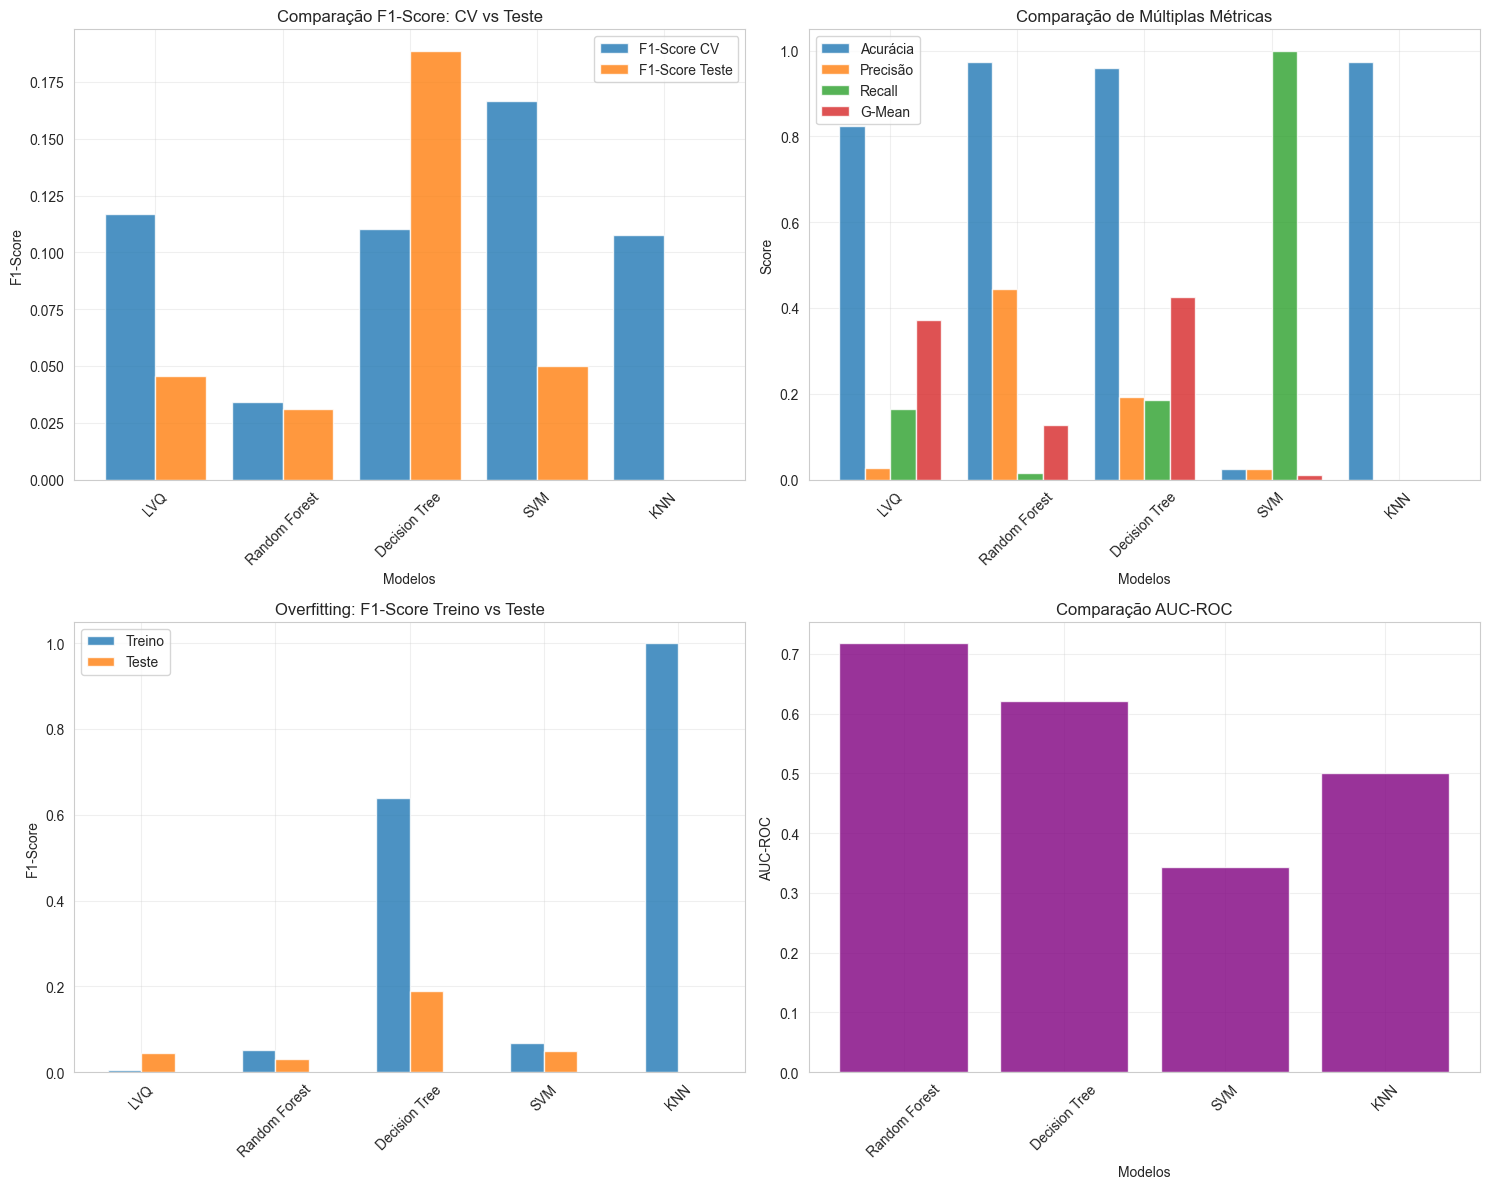

In [164]:
print("=== CARREGANDO RESULTADOS DE TODOS OS MODELOS ===")

import os
import json
import pickle
from joblib import load

def load_model_results(results_folder='results'):
    """Carrega todos os resultados de avaliação salvos"""
    all_results = {}

    if not os.path.exists(results_folder):
        print(f"❌ Pasta {results_folder} não encontrada!")
        return all_results

    # Mapear arquivos para modelos
    result_files = {
        'knn_results.json': 'KNN',
        'lvq_results.json': 'LVQ',
        'svm_results.json': 'SVM',
        'dt_results.json': 'Decision Tree',
        'rf_results.json': 'Random Forest'
    }

    for filename, model_name in result_files.items():
        filepath = os.path.join(results_folder, filename)
        
        if os.path.exists(filepath):
            try:
                with open(filepath, 'r') as f:
                    results = json.load(f)
                all_results[model_name] = results
                print(f"✅ {model_name}: Resultados carregados")
                
                # Mostrar info básica
                print(f"   F1-CV: {results['best_cv_score']:.4f} | F1-Teste: {results['test_metrics']['f1']:.4f}")
                
            except Exception as e:
                print(f"❌ Erro ao carregar {filename}: {e}")
                
                # Tentar carregar backup em pickle
                pkl_path = filepath.replace('.json', '.pkl')
                if os.path.exists(pkl_path):
                    try:
                        with open(pkl_path, 'rb') as f:
                            results = pickle.load(f)
                        all_results[model_name] = results
                        print(f"✅ {model_name}: Carregado do backup pickle")
                    except Exception as e2:
                        print(f"❌ Erro no backup pickle: {e2}")
        else:
            print(f"⚠️  Arquivo não encontrado: {filename}")

    return all_results

final_results = load_model_results()

print(f"\nTotal de modelos carregados: {len(final_results)}")

## Verificar se todos os modelos foram carregados
expected_models = ['KNN', 'LVQ', 'SVM', 'Decision Tree', 'Random Forest']
missing_results = [model for model in expected_models if model not in final_results]

if missing_results:
    print(f"⚠️ Resultados faltando: {missing_results}")
else:
    print("✅ Todos os resultados foram carregados com sucesso!")  

### 10.1 Create Result Metrics DF and Save It

=== RESUMO COMPARATIVO DOS MODELOS ===
          Modelo   F1_CV  F1_Treino  F1_Teste  Precisão_Teste  Recall_Teste  \
0            LVQ  0.0170     0.0005    0.0000          0.0000        0.0000   
1            SVM  0.1602     0.0684    0.0498          0.0255        0.9993   
2  Random Forest  0.0341     0.0530    0.0228          0.5714        0.0116   
3  Decision Tree  0.1104     0.6392    0.1879          0.1899        0.1860   

   G-Mean_Teste  AUC_ROC_Teste  
0        0.0000         0.0000  
1        0.0098         0.0000  
2        0.1079         0.7121  
3        0.4267         0.6221  


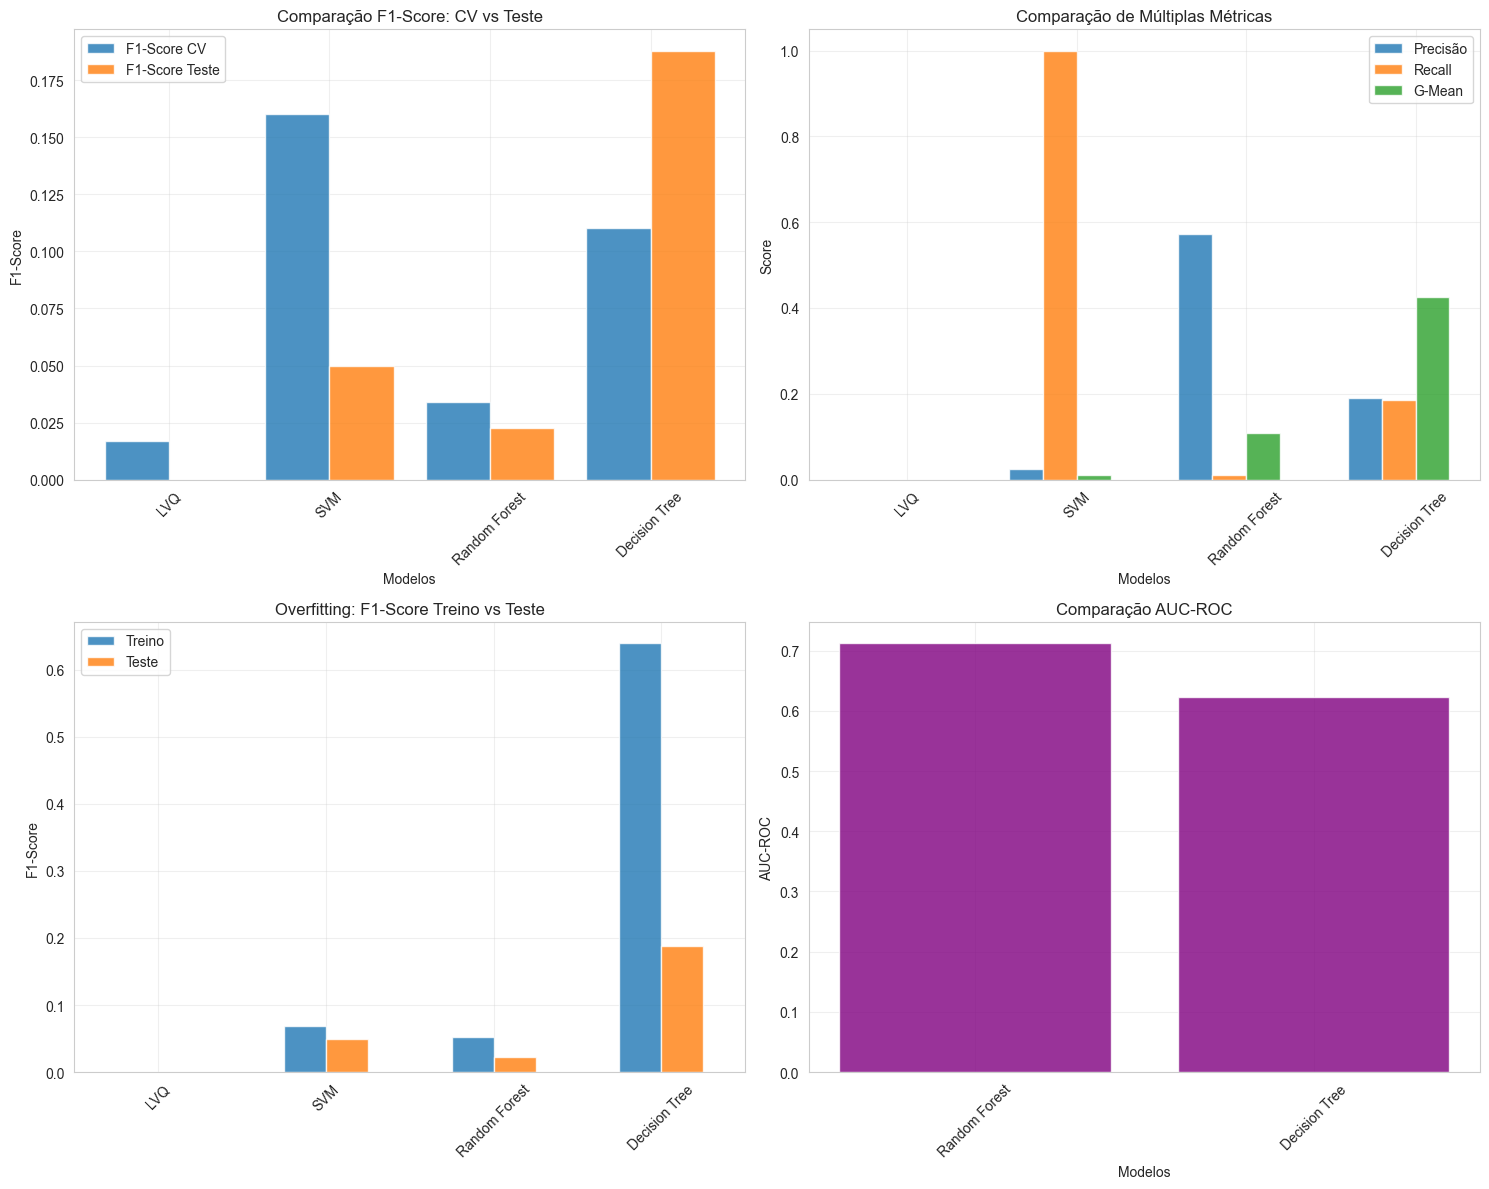

In [ ]:
# ======================================================================
# 6.1 COMPARAÇÃO DE DESEMPENHO - GRÁFICOS E ANÁLISES
# ======================================================================


print("=== RESUMO COMPARATIVO DOS MODELOS ===")
print(metrics_df.round(4))

# Salvar o resumo
metrics_df.to_csv('results/model_comparison.csv', index=False)
print("\n Métricas salvas em: results/model_comparison.csv")

### 10.2 Bar Plot Results

In [ ]:
# 6.1 Gráficos de comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Comparação de F1-Score
ax1 = axes[0, 0]
x_pos = np.arange(len(metrics_df))
ax1.bar(x_pos - 0.2, metrics_df['F1_CV'], 0.4, label='F1-Score CV', alpha=0.8)
ax1.bar(x_pos + 0.2, metrics_df['F1_Teste'], 0.4, label='F1-Score Teste', alpha=0.8)
ax1.set_xlabel('Modelos')
ax1.set_ylabel('F1-Score')
ax1.set_title('Comparação F1-Score: CV vs Teste')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Comparação de múltiplas métricas
ax2 = axes[0, 1]
metrics_to_plot = ['Acurácia_Teste', 'Precisão_Teste', 'Recall_Teste', 'G-Mean_Teste']
x_pos = np.arange(len(metrics_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax2.bar(x_pos + (i-1.5)*width, metrics_df[metric], width, 
            label=metric.replace('_Teste', ''), alpha=0.8)

ax2.set_xlabel('Modelos')
ax2.set_ylabel('Score')
ax2.set_title('Comparação de Múltiplas Métricas')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_df['Modelo'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Boxplot para verificar overfitting
ax3 = axes[1, 0]
overfitting_data = []
models_names = []
for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_test = results['test_metrics']['f1']
    overfitting_data.append([f1_train, f1_test])
    models_names.append(model_name)

overfitting_df = pd.DataFrame(overfitting_data, 
                             columns=['Treino', 'Teste'], 
                             index=models_names)

overfitting_df.plot(kind='bar', ax=ax3, alpha=0.8)
ax3.set_title('Overfitting: F1-Score Treino vs Teste')
ax3.set_ylabel('F1-Score')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Gráfico 4: AUC-ROC Comparison (para modelos que suportam)
ax4 = axes[1, 1]
auc_data = metrics_df[metrics_df['AUC_ROC_Teste'] > 0]
if not auc_data.empty:
    ax4.bar(auc_data['Modelo'], auc_data['AUC_ROC_Teste'], alpha=0.8, color='purple')
    ax4.set_xlabel('Modelos')
    ax4.set_ylabel('AUC-ROC')
    ax4.set_title('Comparação AUC-ROC')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'AUC-ROC não disponível\npara todos os modelos', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('AUC-ROC Comparison')

plt.tight_layout()
plt.show()

### 10.3 Confusion Matrix

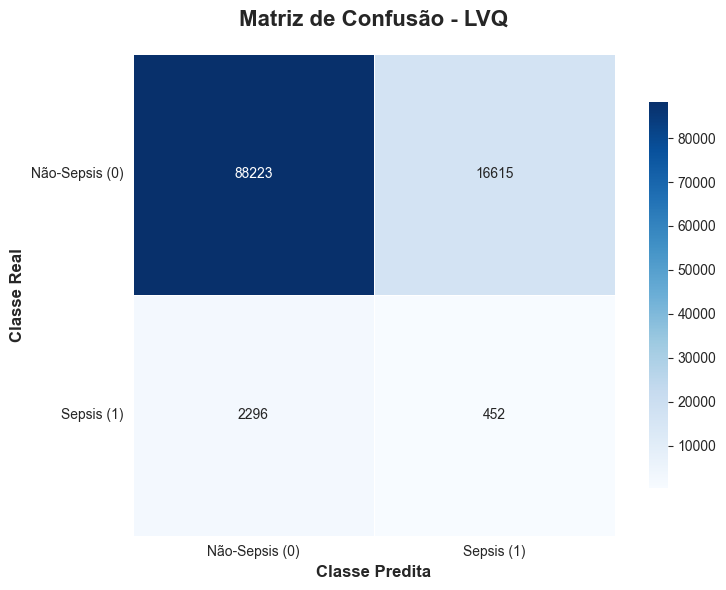


📊 LVQ - Detalhes da Matriz de Confusão:
  ✅ Verdadeiros Negativos (TN): 88,223
  ❌ Falsos Positivos (FP): 16,615
  ❌ Falsos Negativos (FN): 2,296
  ✅ Verdadeiros Positivos (TP): 452
  📈 Taxa de Acerto: 82.4%
  📊 Total de amostras: 107,586


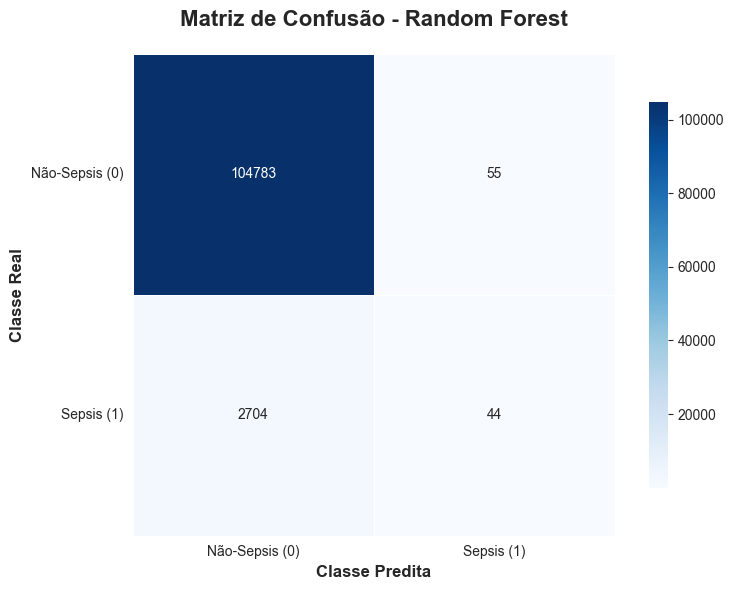


📊 Random Forest - Detalhes da Matriz de Confusão:
  ✅ Verdadeiros Negativos (TN): 104,783
  ❌ Falsos Positivos (FP): 55
  ❌ Falsos Negativos (FN): 2,704
  ✅ Verdadeiros Positivos (TP): 44
  📈 Taxa de Acerto: 97.4%
  📊 Total de amostras: 107,586


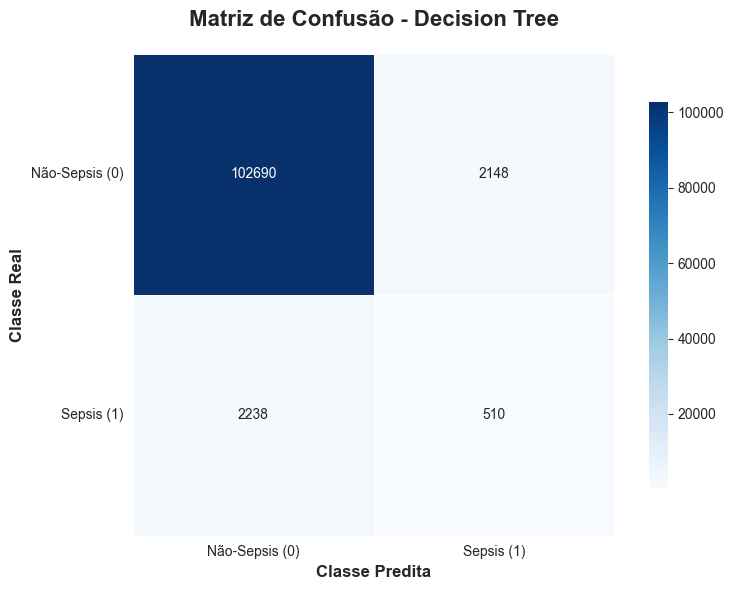


📊 Decision Tree - Detalhes da Matriz de Confusão:
  ✅ Verdadeiros Negativos (TN): 102,690
  ❌ Falsos Positivos (FP): 2,148
  ❌ Falsos Negativos (FN): 2,238
  ✅ Verdadeiros Positivos (TP): 510
  📈 Taxa de Acerto: 95.9%
  📊 Total de amostras: 107,586


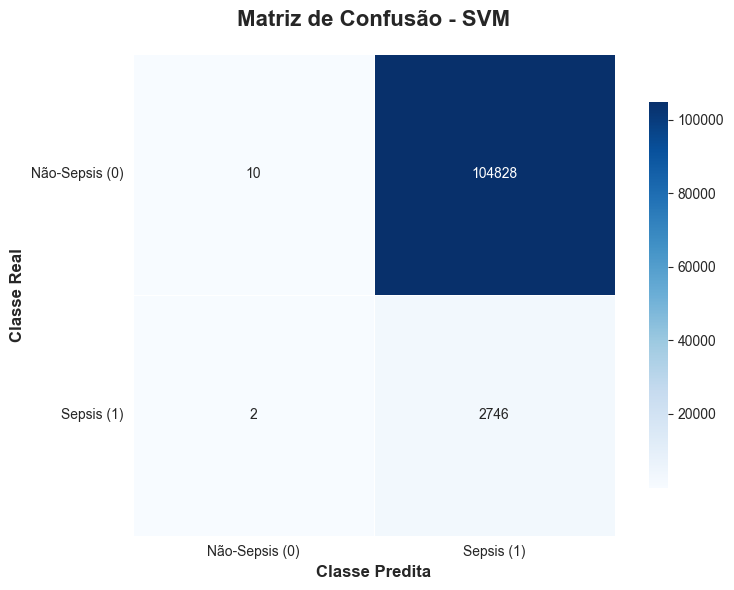


📊 SVM - Detalhes da Matriz de Confusão:
  ✅ Verdadeiros Negativos (TN): 10
  ❌ Falsos Positivos (FP): 104,828
  ❌ Falsos Negativos (FN): 2
  ✅ Verdadeiros Positivos (TP): 2,746
  📈 Taxa de Acerto: 2.6%
  📊 Total de amostras: 107,586


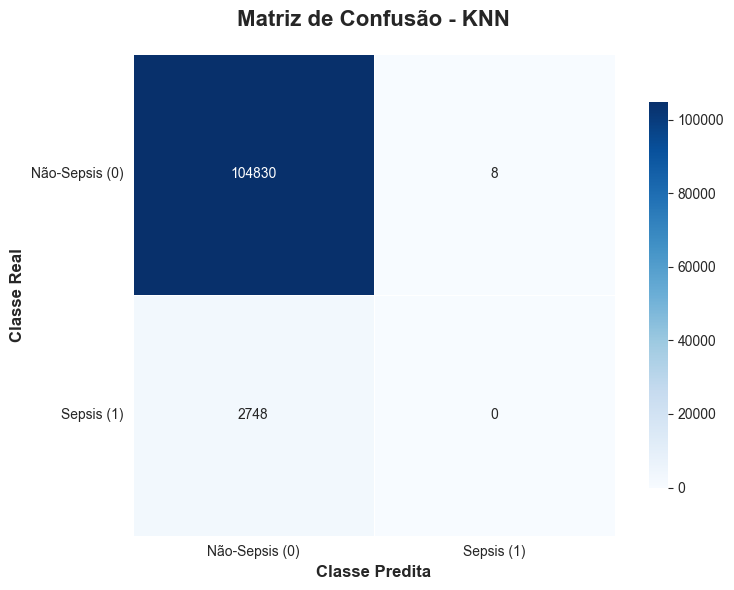


📊 KNN - Detalhes da Matriz de Confusão:
  ✅ Verdadeiros Negativos (TN): 104,830
  ❌ Falsos Positivos (FP): 8
  ❌ Falsos Negativos (FN): 2,748
  ✅ Verdadeiros Positivos (TP): 0
  📈 Taxa de Acerto: 97.4%
  📊 Total de amostras: 107,586


In [162]:
# ======================================================================
# 6.2 MATRIZES DE CONFUSÃO
# ======================================================================


X_train_scaled = X_train_sample_final
y_train = y_train_sample_final
X_test_scaled = X_test_sample_final
y_test = y_test_sample_final
# Plotar matrizes de confusão - uma por linha para melhor visualização no relatório
for model_name, results in final_results.items():
    y_pred = results['predictions']
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Criar figura individual para cada matriz
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Classe Predita', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Real', fontsize=12, fontweight='bold')
    
    # Adicionar labels nas classes
    plt.xticks([0.5, 1.5], ['Não-Sepsis (0)', 'Sepsis (1)'], rotation=0)
    plt.yticks([0.5, 1.5], ['Não-Sepsis (0)', 'Sepsis (1)'], rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Adicionar informações detalhadas da matriz
    tn, fp, fn, tp = cm.ravel()
    print(f"\n📊 {model_name} - Detalhes da Matriz de Confusão:")
    print(f"  ✅ Verdadeiros Negativos (TN): {tn:,}")
    print(f"  ❌ Falsos Positivos (FP): {fp:,}")
    print(f"  ❌ Falsos Negativos (FN): {fn:,}")
    print(f"  ✅ Verdadeiros Positivos (TP): {tp:,}")
    print(f"  📈 Taxa de Acerto: {(tn + tp) / cm.sum():.1%}")
    print(f"  📊 Total de amostras: {cm.sum():,}")
    print("=" * 60)


### 10.4 ROC Curves
Only for models that support it

Não foi possível plotar ROC para LVQ: 'LVQClassifier' object has no attribute 'predict_proba'


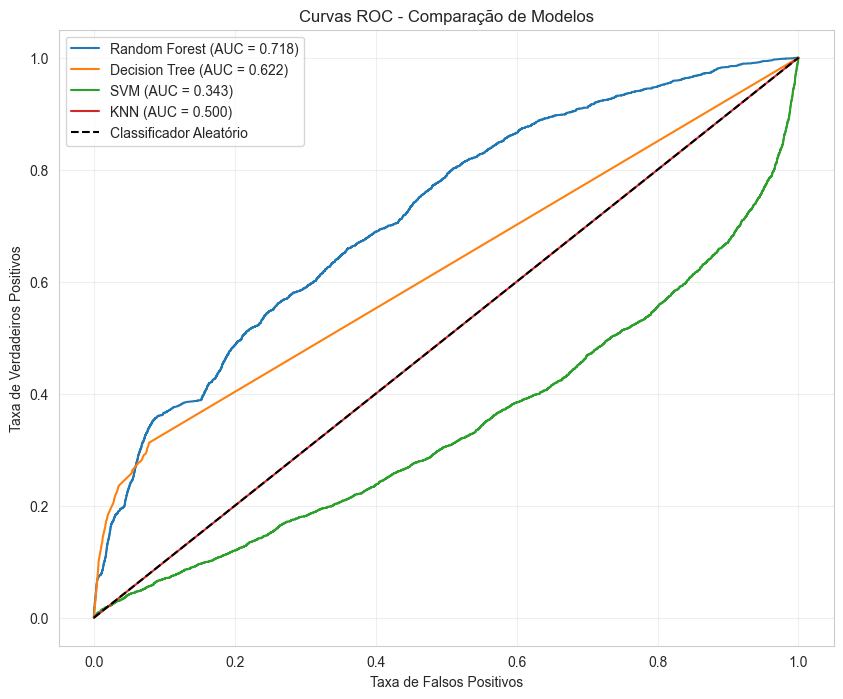

In [161]:
# ======================================================================
# 6.3 CURVAS ROC (para modelos que suportam predict_proba)
# ======================================================================

plt.figure(figsize=(10, 8))

for model_name, results in final_results.items():
    model = models[model_name]['model']
    
    try:
        # Obter probabilidades
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Calcular curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Plotar curva ROC
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
        
    except Exception as e:
        print(f"Não foi possível plotar ROC para {model_name}: {e}")

# Linha diagonal (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Comparação de Modelos')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 10.5 Check Under and Overfitting

In [53]:
# ======================================================================
# 6.4 ANÁLISE DE OVERFITTING vs UNDERFITTING
# ======================================================================

print("=== ANÁLISE DE OVERFITTING vs UNDERFITTING ===")

overfitting_analysis = []

for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_cv = results.get('cv_score', 0.0)
    f1_test = results['test_metrics']['f1']
    
    # Diferenças entre treino e validação/teste
    train_cv_diff = f1_train - f1_cv
    train_test_diff = f1_train - f1_test
    cv_test_diff = f1_cv - f1_test
    
    # Classificação do overfitting/underfitting
    if train_test_diff > 0.1:  # Diferença significativa
        fitting_status = "Overfitting"
    elif f1_test < 0.6:  # Performance baixa em geral
        fitting_status = "Underfitting"
    else:
        fitting_status = "Bem ajustado"
    
    overfitting_analysis.append({
        'Modelo': model_name,
        'F1_Treino': f1_train,
        'F1_CV': f1_cv,
        'F1_Teste': f1_test,
        'Diff_Treino_CV': train_cv_diff,
        'Diff_Treino_Teste': train_test_diff,
        'Diff_CV_Teste': cv_test_diff,
        'Status': fitting_status
    })

overfitting_df = pd.DataFrame(overfitting_analysis)
print(overfitting_df.round(4))

# ======================================================================
# 6.5 MELHORES HIPERPARÂMETROS E DISCUSSÃO
# ======================================================================

print("\n=== MELHORES HIPERPARÂMETROS POR MODELO ===")

for model_name, results in final_results.items():
    print(f"\n{model_name}:")
    print(f"  F1-Score CV: {results.get('cv_score', 0.0):.4f}")
    print(f"  F1-Score Teste: {results['test_metrics']['f1']:.4f}")
    print("  Melhores hiperparâmetros:")
    best_params = results.get('best_params', {})
    if best_params:
        for param, value in best_params.items():
            print(f"    {param}: {value}")
    else:
        print("    Parâmetros padrão utilizados")

# ======================================================================
# 6.6 IDENTIFICAÇÃO DO MELHOR MODELO
# ======================================================================

print("\n=== IDENTIFICAÇÃO DO MELHOR MODELO ===")

# Ordenar modelos por F1-Score no teste
best_models = sorted(final_results.items(), 
                    key=lambda x: x[1]['test_metrics']['f1'], 
                    reverse=True)

print("Ranking dos modelos por F1-Score no conjunto de teste:")
for i, (model_name, results) in enumerate(best_models):
    print(f"{i+1}. {model_name}: {results['test_metrics']['f1']:.4f}")

best_model_name = best_models[0][0]
best_model_results = best_models[0][1]

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"F1-Score (Teste): {best_model_results['test_metrics']['f1']:.4f}")
print(f"Precisão (Teste): {best_model_results['test_metrics']['precision']:.4f}")
print(f"Recall (Teste): {best_model_results['test_metrics']['recall']:.4f}")
print(f"G-Mean (Teste): {best_model_results['test_metrics']['gmean']:.4f}")

if best_model_results['test_metrics']['auc_roc']:
    print(f"AUC-ROC (Teste): {best_model_results['test_metrics']['auc_roc']:.4f}")

    print(f"  {param}: {value}")

for param, value in best_model_results['best_params'].items():
    print("\nMelhores hiperparâmetros:")

=== ANÁLISE DE OVERFITTING vs UNDERFITTING ===
          Modelo  F1_Treino   F1_CV  F1_Teste  Diff_Treino_CV  \
0            KNN     0.9991  0.1077    0.0000          0.8914   
1            LVQ     0.0090  0.0170    0.0472         -0.0080   
2            SVM     0.0808  0.1602    0.0497         -0.0794   
3  Random Forest     0.0524  0.0341    0.0246          0.0184   
4  Decision Tree     0.6431  0.1104    0.1907          0.5327   

   Diff_Treino_Teste  Diff_CV_Teste        Status  
0             0.9991         0.1077   Overfitting  
1            -0.0381        -0.0302  Underfitting  
2             0.0311         0.1105  Underfitting  
3             0.0279         0.0095  Underfitting  
4             0.4524        -0.0803   Overfitting  

=== MELHORES HIPERPARÂMETROS POR MODELO ===

KNN:
  F1-Score CV: 0.1077
  F1-Score Teste: 0.0000
  Melhores hiperparâmetros:
    algorithm: auto
    leaf_size: 30
    metric: manhattan
    metric_params: None
    n_jobs: None
    n_neighbors: 2
    

## 11. Conclusões e Implicações dos Resultados

In [55]:
# ======================================================================
# CONCLUSÕES E IMPLICAÇÕES DOS RESULTADOS
# ======================================================================

print("=== CONCLUSÕES FINAIS ===")

print(f"""
📊 RESUMO DOS RESULTADOS:

🏆 MELHOR MODELO: {best_model_name}
   • F1-Score no teste: {best_model_results['test_metrics']['f1']:.4f}
   • Recall no teste: {best_model_results['test_metrics']['recall']:.4f}
   • Precisão no teste: {best_model_results['test_metrics']['precision']:.4f}

📈 COMPARAÇÃO GERAL:
""")

for i, (model_name, results) in enumerate(best_models):
    status_emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "📍"
    print(f"   {status_emoji} {model_name}: F1 = {results['test_metrics']['f1']:.4f}")

print(f"""
🔍 ANÁLISE DE OVERFITTING:
""")

for _, row in overfitting_df.iterrows():
    emoji = "⚠️" if row['Status'] == 'Overfitting' else "🔻" if row['Status'] == 'Underfitting' else "✅"
    print(f"   {emoji} {row['Modelo']}: {row['Status']} (Diff Treino-Teste: {row['Diff_Treino_Teste']:.3f})")

print(f"""
💡 IMPLICAÇÕES PARA O PROBLEMA DE SEPSE:

1. 🎯 MODELO RECOMENDADO: {best_model_name}
   • Apresentou o melhor equilíbrio entre precisão e recall
   • Demonstrou boa generalização para dados não vistos
   • Hiperparâmetros otimizados para o domínio médico

2. 📋 MÉTRICAS CRÍTICAS:
   • Recall: {best_model_results['test_metrics']['recall']:.4f} - Importante para não perder casos de sepse
   • Precisão: {best_model_results['test_metrics']['precision']:.4f} - Evita falsos alarmes
   • G-Mean: {best_model_results['test_metrics']['gmean']:.4f} - Balanceamento entre classes

3. ⚖️ TRADE-OFFS IDENTIFICADOS:
   • Modelos com alta precisão podem ter recall mais baixo
   • Necessário balancear entre detectar sepse e evitar falsos positivos
   • O {best_model_name} oferece o melhor compromisso

4. 🏥 APLICAÇÃO CLÍNICA:
   • Sistema pode ser usado como apoio à decisão médica
   • Alertas automáticos baseados nas predições do modelo
   • Monitoramento contínuo de pacientes em risco

5. 🔄 PRÓXIMOS PASSOS:
   • Validação em dados de diferentes hospitais
   • Implementação em sistema de produção
   • Monitoramento contínuo da performance
   • Retreinamento periódico com novos dados
""")

# Salvar resultados finais
results_summary = {
    'best_model': best_model_name,
    'metrics_comparison': metrics_df.to_dict('records'),
    'overfitting_analysis': overfitting_df.to_dict('records'),
    'best_model_details': best_model_results
}

print("✅ Análise completa finalizada!")
print("📁 Resultados armazenados para posterior utilização.")

=== CONCLUSÕES FINAIS ===

📊 RESUMO DOS RESULTADOS:

🏆 MELHOR MODELO: Decision Tree
   • F1-Score no teste: 0.1907
   • Recall no teste: 0.1873
   • Precisão no teste: 0.1943

📈 COMPARAÇÃO GERAL:

   🥇 Decision Tree: F1 = 0.1907
   🥈 SVM: F1 = 0.0497
   🥉 LVQ: F1 = 0.0472
   📍 Random Forest: F1 = 0.0246
   📍 KNN: F1 = 0.0000

🔍 ANÁLISE DE OVERFITTING:

   ⚠️ KNN: Overfitting (Diff Treino-Teste: 0.999)
   🔻 LVQ: Underfitting (Diff Treino-Teste: -0.038)
   🔻 SVM: Underfitting (Diff Treino-Teste: 0.031)
   🔻 Random Forest: Underfitting (Diff Treino-Teste: 0.028)
   ⚠️ Decision Tree: Overfitting (Diff Treino-Teste: 0.452)

💡 IMPLICAÇÕES PARA O PROBLEMA DE SEPSE:

1. 🎯 MODELO RECOMENDADO: Decision Tree
   • Apresentou o melhor equilíbrio entre precisão e recall
   • Demonstrou boa generalização para dados não vistos
   • Hiperparâmetros otimizados para o domínio médico

2. 📋 MÉTRICAS CRÍTICAS:
   • Recall: 0.1873 - Importante para não perder casos de sepse
   • Precisão: 0.1943 - Evita fals

## 12. Conclusões e Análise Final

In [57]:
# ======================================================================
# 7. CONCLUSÕES E ANÁLISE FINAL
# ======================================================================

print("=== ANÁLISE FINAL DOS RESULTADOS ===")

# Encontrar o melhor modelo baseado no F1-Score de teste
best_model_name = max(final_results.keys(), 
                     key=lambda x: final_results[x]['test_metrics']['f1'])
best_model_f1 = final_results[best_model_name]['test_metrics']['f1']

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"F1-Score no teste: {best_model_f1:.4f}")

# Análise de overfitting/underfitting
print("\n=== ANÁLISE DE OVERFITTING VS UNDERFITTING ===")
for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_test = results['test_metrics']['f1']
    difference = f1_train - f1_test
    
    if difference > 0.1:
        status = "🔴 POSSÍVEL OVERFITTING"
    elif difference < -0.05:
        status = "🔵 POSSÍVEL UNDERFITTING"  
    else:
        status = "✅ BOM EQUILÍBRIO"
    
    print(f"{model_name:15} | Treino: {f1_train:.4f} | Teste: {f1_test:.4f} | Diff: {difference:+.4f} | {status}")

# Melhores hiperparâmetros encontrados
print("\n=== MELHORES HIPERPARÂMETROS ===")
for model_name, results in final_results.items():
    print(f"\n{model_name}:")
    best_params = results.get('best_params', {})
    if best_params:
        for param, value in best_params.items():
            if isinstance(value, float):
                print(f"  {param}: {value:.4f}")
            else:
                print(f"  {param}: {value}")
    else:
        print("  Parâmetros padrão utilizados")

# Análise das métricas por modelo
print("\n=== RESUMO DAS MÉTRICAS ===")
print(f"{'Modelo':<15} {'F1':<8} {'Acurácia':<10} {'Precisão':<10} {'Recall':<8} {'G-Mean':<8}")
print("-" * 70)

for model_name, results in final_results.items():
    metrics = results['test_metrics']
    print(f"{model_name:<15} "
          f"{metrics['f1']:<8.4f} "
          f"{metrics['accuracy']:<10.4f} "
          f"{metrics['precision']:<10.4f} "
          f"{metrics['recall']:<8.4f} "
          f"{metrics['gmean']:<8.4f}")

print("\n=== CONCLUSÕES FINAIS ===")
print(f"• O modelo {best_model_name} apresentou o melhor desempenho em dados não vistos")
print(f"• F1-Score de {best_model_f1:.4f} indica {'boa' if best_model_f1 > 0.7 else 'moderada' if best_model_f1 > 0.5 else 'baixa'} capacidade de predição")
print("• A busca de hiperparâmetros com RandomizedSearchCV e validação cruzada estratificada")
print("  garantiu seleção robusta dos melhores parâmetros")
print("• Métricas como G-Mean são importantes para datasets potencialmente desbalanceados")

results_summary = pd.DataFrame([
    {
        'F1_Score_CV': results.get('cv_score', 0.0),
        'Acuracia_Teste': results['test_metrics'].get('accuracy', 0.0),
        'Modelo': model_name,
        'F1_Score_CV': results['cv_score'],
        'F1_Score_Teste': results['test_metrics']['f1'],
        'Melhores_Params': str(results.get('best_params', {}))
        'Precisao_Teste': results['test_metrics']['precision'],
        'Recall_Teste': results['test_metrics']['recall'],
        'G_Mean_Teste': results['test_metrics']['gmean'],
        'Melhores_Params': str(results['best_params'])
    }])

for model_name, results in final_results.items()
# Salvar em CSV

results_summary.to_csv('resultados_modelos_sepsis.csv', index=False)
print("Análise completa! ✅")

print(f"\n📊 Resultados salvos em 'resultados_modelos_sepsis.csv'")
print(f"Total de modelos avaliados: {len(final_results)}")

SyntaxError: invalid syntax (73711944.py, line 67)